In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import h5py
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

In [3]:
def collect_data(filename):
    
    # Open the file
    with h5py.File(filename, 'r') as f:
        # locs
        locs = f['locs']
        
        x_values = locs['x'][:]
        y_values = locs['y'][:]
        
    data = {
        'x': x_values,
        'y': y_values,
    }
    
    return pd.DataFrame(data)

def collect_group_data(hdf5_file, dataset_name):
    group_data_list = []

    with h5py.File(hdf5_file, 'r') as f:
        # Access the dataset
        dataset = f[dataset_name]

        # Extract the 'group', 'x', and 'y' fields
        group_data = dataset['group'][:]
        x_data = dataset['x'][:]
        y_data = dataset['y'][:]

        # Find unique groups
        unique_groups = np.unique(group_data)

        # Collect data for each group
        for group in unique_groups:
            indices = np.where(group_data == group)
            group_dict = {
                'group': int(group),
                'x': x_data[indices].tolist(),
                'y': y_data[indices].tolist()
            }
            group_data_list.append(group_dict)
    
    return group_data_list

def find_clusters_k_means(data, k):
    kmeans = KMeans(init="k-means++", n_clusters=k, n_init=4)
    kmeans.fit(data)
    return kmeans.labels_

def find_com(data, labels):
    com = []
    for i in range(max(labels)+1):
        x = np.mean(data['x'][labels == i])
        y = np.mean(data['y'][labels == i])
        com.append((x, y))
    return com
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.
    """
    pi2 = np.pi / 2

    # Get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # Calculate edge angles
    edges = hull_points[1:] - hull_points[:-1]
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # Find rotation matrices
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles - pi2),
        np.cos(angles + pi2),
        np.cos(angles)
    ]).T
    rotations = rotations.reshape((-1, 2, 2))

    # Apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # Find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # Find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # Return the best box
    x1, x2 = max_x[best_idx], min_x[best_idx]
    y1, y2 = max_y[best_idx], min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

def distance_to_line(point, line_start, line_end):
    """Calculate the perpendicular distance from a point to a line."""
    if np.all(line_start == line_end):
        return np.linalg.norm(point - line_start)
    return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))

def find_closest_side(points, rectangle):
    """Find the side of the rectangle with the most points closest to it."""
    distances = np.zeros((4, len(points)))
    for i in range(4):
        line_start, line_end = rectangle[i], rectangle[(i + 1) % 4]
        for j, point in enumerate(points):
            distances[i, j] = distance_to_line(point, line_start, line_end)
    min_distances = np.argmin(distances, axis=0)
    closest_side = np.bincount(min_distances).argmax()
    return closest_side

def find_rotation_angle(rectangle, closest_side):
    """
    Find the rotation angle to make the closest side the bottom side.
    """
    rotation_angle = -np.arctan2(
        rectangle[(closest_side + 1) % 4, 1] - rectangle[closest_side, 1],
        rectangle[(closest_side + 1) % 4, 0] - rectangle[closest_side, 0]
    )
    return rotation_angle + np.pi

def rotate_points(points, rotation_angle, pivot):
    """
    Rotate the given points around the pivot by the given rotation angle.
    """
    rotation_matrix = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle)],
        [np.sin(rotation_angle), np.cos(rotation_angle)]
    ])
    rotated_points = np.dot(points - pivot, rotation_matrix.T) + pivot
    return rotated_points



def find_middle_left_most_com(rotated_com):
    # Sort each com in rotated_com based on its x value and take the first 3
    sorted_com = rotated_com[rotated_com[:, 0].argsort()][:3]
    second_highest_com = None
    
    # Find the second highest y value in sorted_com
    for com in sorted_com:
        if com[1] != max(sorted_com[:, 1]) and com[1] != min(sorted_com[:, 1]):
            second_highest_com = com
            break
    return second_highest_com

def find_right_most_coms(rotated_com):
    # Sort each com in rotated_com based on its x value
    sorted_com = rotated_com[rotated_com[:, 0].argsort()]
    right_most_com = sorted_com[-1]
    second_right_most_com = sorted_com[-2]
    return right_most_com, second_right_most_com

def find_center_of_rectangle(rectangle):
    return np.mean(rectangle, axis=0)


def find_robot(rotated_com):
    
    #finding the center of the rectangle
    center_x, center_y = find_center_of_rectangle(rotated_com)
    
    distances = np.sqrt((rotated_com[:, 0] - center_x) ** 2 + (rotated_com[:, 1] - center_y) ** 2)
    closest_com_index = np.argmin(distances)
    closest_com = rotated_com[closest_com_index]
    
    return closest_com
#drawing line between two points without using cv2
def draw_line_between_points(p1, p2, color='white'):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color)
    
def intersection_between_point_line(point, line):
    x0, y0 = point
    x1, y1 = line[0]
    x2, y2 = line[1]
    if x1 == x2:
        return x1, y0
    m = (y2 - y1) / (x2 - x1)
    c = y1 - m * x1
    x = (m * y0 + x0 - m * c) / (m ** 2 + 1)
    y = m * x + c
    return x, y
    

def draw_line_between_point_and_line( p1, p2, p3):
    
    #finding the intersection point
    right_line = np.array([p1, p2])
    intersection_x, intersection_y = intersection_between_point_line(p3, right_line)
    intersection_point = np.array([intersection_x, intersection_y])
    
    #plotting the points between the points p3 and intersection point
    plt.plot([p3[0], intersection_point[0]], [p3[1], intersection_point[1]], color='magenta')

def calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com):
    def distance_point_to_line(point, line):
        x0, y0 = point
        x1, y1 = line[0]
        x2, y2 = line[1]
        return np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1) / np.sqrt((y2-y1)**2 + (x2-x1)**2)

    right_line = np.array([right_most_com, second_right_most_com])
    intersection_point = intersection_between_point_line(robot_com, right_line)
    normalizing_point = intersection_between_point_line(second_highest_com, right_line)
    robot_distance = distance_point_to_line(robot_com, right_line)
    normalizing_distance = distance_point_to_line(second_highest_com, right_line)
    ratio = robot_distance / normalizing_distance

    plt.axes().set_facecolor('black')
    ax = plt.gca()
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=10)
    plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=10)
    plt.scatter(right_most_com[0], right_most_com[1], color='magenta', s=10)
    plt.scatter(second_right_most_com[0], second_right_most_com[1], color='magenta', s=10)
    plt.scatter(robot_com[0], robot_com[1], color='magenta', s=10)

    draw_line_between_points(right_most_com, second_right_most_com, color='magenta')
    draw_line_between_point_and_line(right_most_com, second_right_most_com, robot_com)
    draw_line_between_point_and_line(second_right_most_com, right_most_com, second_highest_com)

    plt.show()

    return ratio


In [4]:
def plot_helper(data=None, labels=None, com=None, rotated_data=None, rotated_com=None, rotated_rect=None, second_highest_com=None, right_most_com=None, second_right_most_com=None, robot_com=None, title="Plot"):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_facecolor('black')
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    
    if data is not None and labels is not None:
        plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', s=10, alpha=0.5)
    elif data is not None:
        plt.scatter(data['x'], data['y'], s=10, alpha=0.5)
    
    if com is not None and len(com) > 0:
        com = np.array(com)
        plt.scatter(com[:, 0], com[:, 1], c='red', s=100, label='COMs')
    
    if rotated_data is not None and rotated_data.size > 0:
        plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    
    if rotated_com is not None and rotated_com.size > 0:
        plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=100, label='Rotated COMs')
   
    if rotated_rect is not None and rotated_rect.size > 0:
        for i in range(4):
            plt.plot([rotated_rect[i, 0], rotated_rect[(i + 1) % 4, 0]], 
                     [rotated_rect[i, 1], rotated_rect[(i + 1) % 4, 1]], 'b-')

    if second_highest_com is not None and len(second_highest_com) > 0:
        plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=100, label='Second Highest COM')
    

    if right_most_com is not None and len(right_most_com) > 0:
        plt.scatter(right_most_com[0], right_most_com[1], color='magenta', s=100, label='Right Most COM')
   
    if second_right_most_com is not None and len(second_right_most_com) > 0:
        plt.scatter(second_right_most_com[0], second_right_most_com[1], color='magenta', s=100, label='Second Right Most COM')
    
    if robot_com is not None and len(robot_com) > 0:
        plt.scatter(robot_com[0], robot_com[1], color='magenta', s=100, label='Robot COM')
    
    
    plt.title(title)
    plt.legend()
    plt.show()




def process_origami_ratio(filename, k):
    print("Starting process_origami_ratio")
    
    data = collect_data(filename)
    print("Data collected:\n", data.head())
    plot_helper(data=data, title="Initial Data")
    
    labels = find_clusters_k_means(data, k)
    print("K-Means labels:\n", labels)
    plot_helper(data=data, labels=labels, title="K-Means Clustering")

    com = find_com(data, labels)
    print("Centers of Mass (COM):\n", com)
    plot_helper(data=data, labels=labels, com=com, title="Centers of Mass")

    min_bounding_rect = minimum_bounding_rectangle(np.array(com))
    print("Minimum Bounding Rectangle:\n", min_bounding_rect)
    
    closest_side = find_closest_side(np.array(com), min_bounding_rect)
    print("Closest side of bounding rectangle:\n", closest_side)
    
    rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
    print("Rotation angle:\n", rotation_angle)
    
    rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
    print("Rotated Data:\n", rotated_data[:5])
    
    rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
    print("Rotated Centers of Mass (COM):\n", rotated_com)
    
    rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
    plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title="Rotated Data and COMs")

    second_highest_com = find_middle_left_most_com(rotated_com)
    print("Second Highest COM:\n", second_highest_com)
    
    right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
    print("Right Most COM:\n", right_most_com)
    print("Second Right Most COM:\n", second_right_most_com)
    
    robot_com = find_robot(rotated_com)
    print("Robot COM:\n", robot_com)

    ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
    print("Ratio:\n", ratio)

    return ratio


Starting process_origami_ratio
Data collected:
             x          y
0  111.875267  60.029800
1  111.827614  60.045071
2  111.803627  60.154224
3  111.851440  60.342262
4  111.837921  60.320156


/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


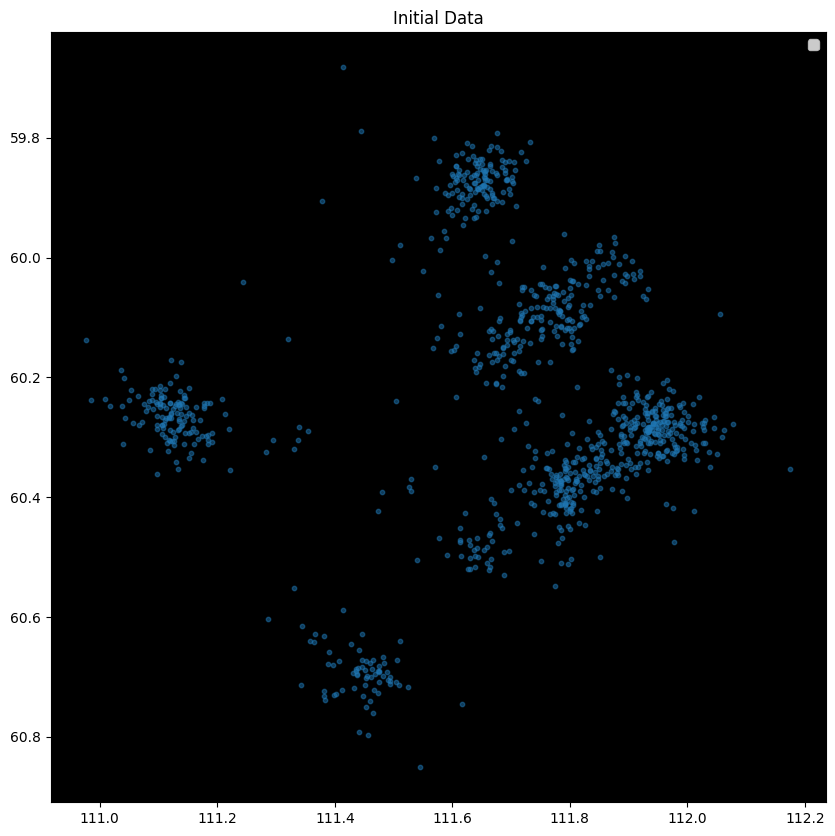

K-Means labels:
 [2 2 2 0 0 7 7 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 2 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 2 2 2 2 2 2 2 2 2 2 2 2 2 7 7 2 2 2 7 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 4 4 4 3 3 3 3 3 0 0 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 7 0
 0 5 5 5 5 5 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 5 5 5 6 0 5 5 5 5 5 5 5 5 5 5 5 7 0 0 5 5 6 1 5 5 4 4 4 4 1 1 0
 0 0 0 1 4 4 0 0 0 0 0 0 5 5 0 0 1 1 1 1 1 1 4 7 7 0 0 5 5 5 5 5 5 5 0 5 0
 5 0 0 0 0 0 0 0 2 7 7 7 7 7 7 7 7 7 7 2 2 2 2 0 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 0 0 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 4 4 4 4 6 6 0 6 6 6 6 2
 2 4 4 4 1 1 1 1 1 1 1 2 2 7 7 7 5 5 5 6 6 6 6 6 6 6 6 6 1 1 1 1 1 7 1 1 1
 1 4 4 0 0 6 6 6 6 6 6 6 6 6 6 6 6 3 3 4 4 4 4 4 4 4 7 7 7 7 7 7 6 4 5 5 5
 0 0 0 7 7 7 7 4 4 4 4 4 4 4 4 4 4 1 4 2 2 2 2 2 2 3 3 3 3 1 5 5 5 5 5 3 3
 4 7 2 2 2 6 0 0 7 1 1 0 0 0 0 5 5 1 1 2 4 4 4 4 4 3 3 3 3 3 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 2 5 5 5 5 7 7
 7 7 7 6

/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


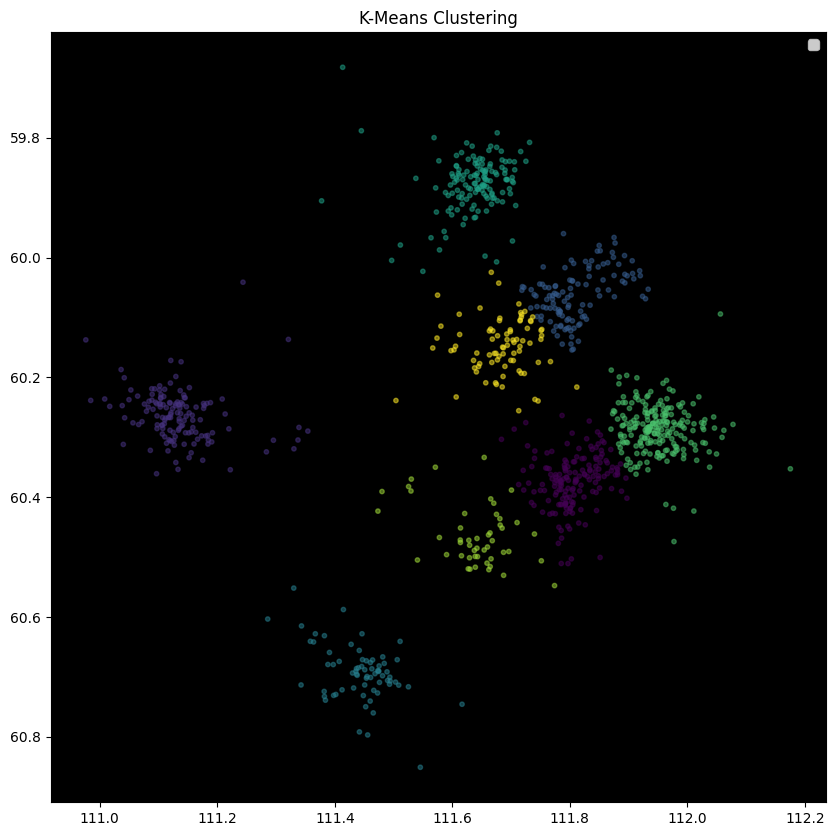

Centers of Mass (COM):
 [(np.float32(111.805565), np.float32(60.373165)), (np.float32(111.1327), np.float32(60.26338)), (np.float32(111.811005), np.float32(60.06247)), (np.float32(111.443954), np.float32(60.693012)), (np.float32(111.6368), np.float32(59.877396)), (np.float32(111.95023), np.float32(60.285942)), (np.float32(111.6388), np.float32(60.46383)), (np.float32(111.68343), np.float32(60.147842))]


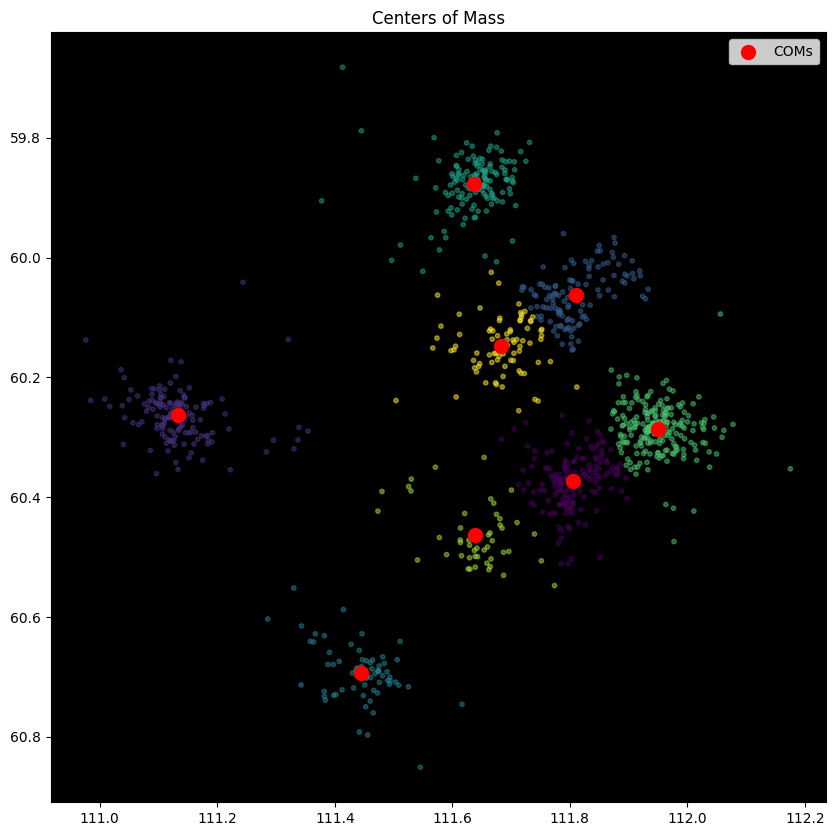

Minimum Bounding Rectangle:
 [[111.97969055  60.2828064 ]
 [111.65727234  59.86171722]
 [111.121521    60.27193069]
 [111.44393921  60.69301987]]
Closest side of bounding rectangle:
 3
Rotation angle:
 3.795052941504049
Rotated Data:
 [[110.69827548  60.95738577]
 [110.74539475  60.9742316 ]
 [110.83079857  60.90214766]
 [110.9071507   60.72378085]
 [110.90444564  60.7495517 ]]
Rotated Centers of Mass (COM):
 [[110.96236221  60.72713391]
 [111.42986469  61.22336407]
 [110.7691596   60.97051454]
 [111.44392246  60.69301665]
 [110.79496     61.22336429]
 [110.79447137  60.70843825]
 [111.14988774  60.7565298 ]
 [110.92235053  60.98028498]]


/tmp/ipykernel_2100/245223972.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


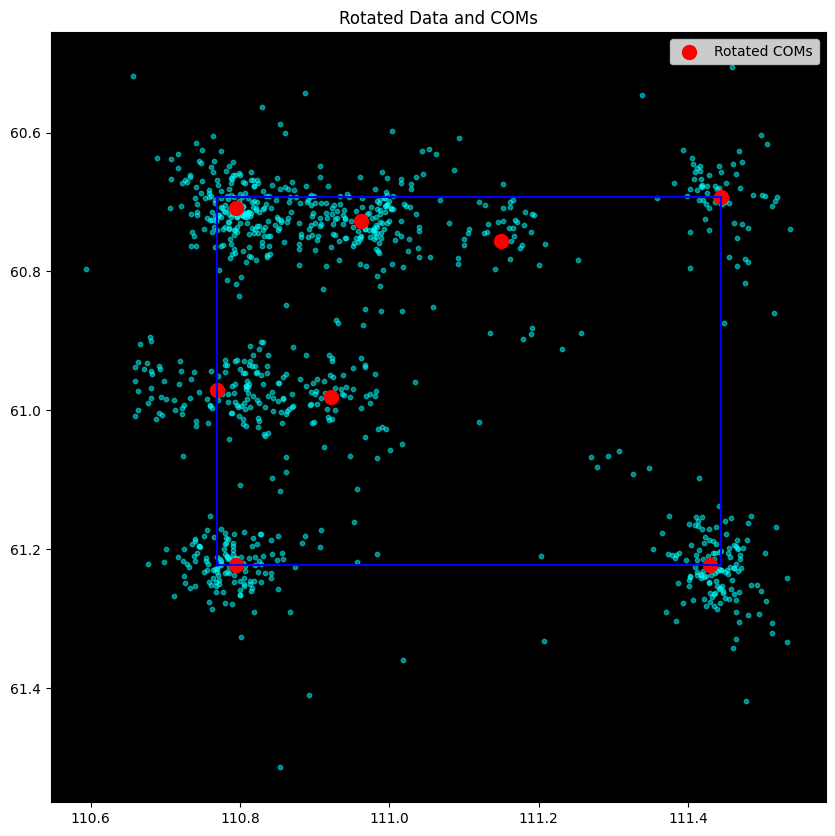

Second Highest COM:
 [110.7691596   60.97051454]
Right Most COM:
 [111.44392246  60.69301665]
Second Right Most COM:
 [111.42986469  61.22336407]
Robot COM:
 [110.92235053  60.98028498]


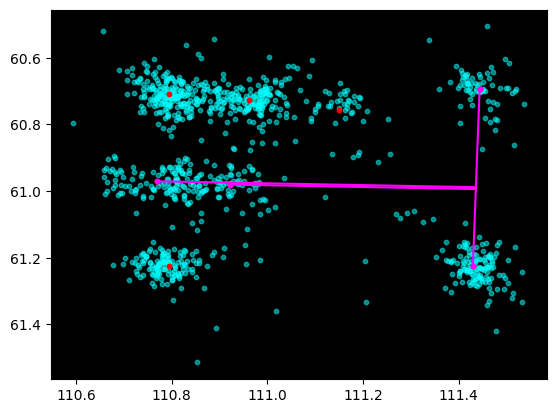

Ratio:
 0.7700805574794465


In [5]:
ratio = process_origami_ratio('data/test_1.hdf5', 8)

In [6]:
def process_multiple_origami_ratio(filename, k):
    print("Starting process_multiple_origami_ratio")
    
    # Collect data for each group
    group_data_list = collect_group_data(filename, 'locs')
    
    # Process each group
    for group_data in group_data_list:
        group_id = group_data['group']
        data = pd.DataFrame({
            'x': group_data['x'],
            'y': group_data['y']
        })
        print(f"\nProcessing Group {group_id}")
        print("Data collected:\n", data.head())
        plot_helper(data=data, title=f"Initial Data - Group {group_id}")
        
        labels = find_clusters_k_means(data, k)
        print("K-Means labels:\n", labels)
        plot_helper(data=data, labels=labels, title=f"K-Means Clustering - Group {group_id}")
    
        com = find_com(data, labels)
        print("Centers of Mass (COM):\n", com)
        plot_helper(data=data, labels=labels, com=com, title=f"Centers of Mass - Group {group_id}")
    
        min_bounding_rect = minimum_bounding_rectangle(np.array(com))
        print("Minimum Bounding Rectangle:\n", min_bounding_rect)
        
        closest_side = find_closest_side(np.array(com), min_bounding_rect)
        print("Closest side of bounding rectangle:\n", closest_side)
        
        rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
        print("Rotation angle:\n", rotation_angle)
        
        rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
        print("Rotated Data:\n", rotated_data[:5])
        
        rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
        print("Rotated Centers of Mass (COM):\n", rotated_com)
        
        rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
        plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title=f"Rotated Data and COMs - Group {group_id}")
    
        second_highest_com = find_middle_left_most_com(rotated_com)
        print("Second Highest COM:\n", second_highest_com)
        
        right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
        print("Right Most COM:\n", right_most_com)
        print("Second Right Most COM:\n", second_right_most_com)
        
        robot_com = find_robot(rotated_com)
        print("Robot COM:\n", robot_com)
    
        ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
        print("Ratio:\n", ratio)
    
    return ratio



Starting process_multiple_origami_ratio



Processing Group 0
Data collected:
            x         y
0  42.897629  5.893465
1  42.816818  5.834262
2  42.830162  5.812670
3  42.875660  5.817399
4  42.836132  5.822851


/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


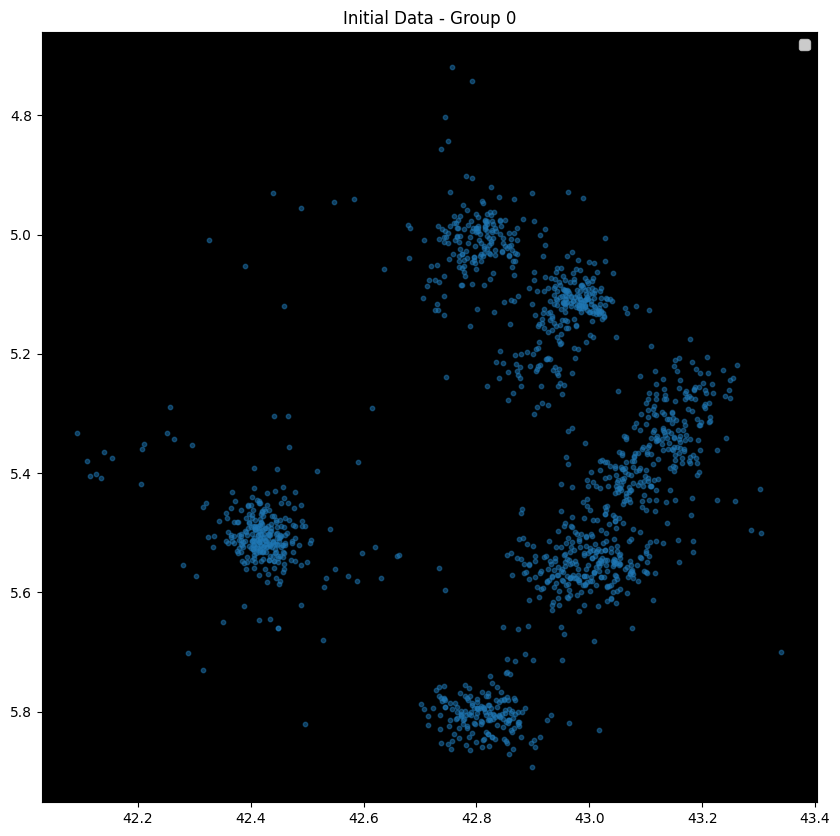

K-Means labels:
 [3 3 3 ... 0 3 2]


/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


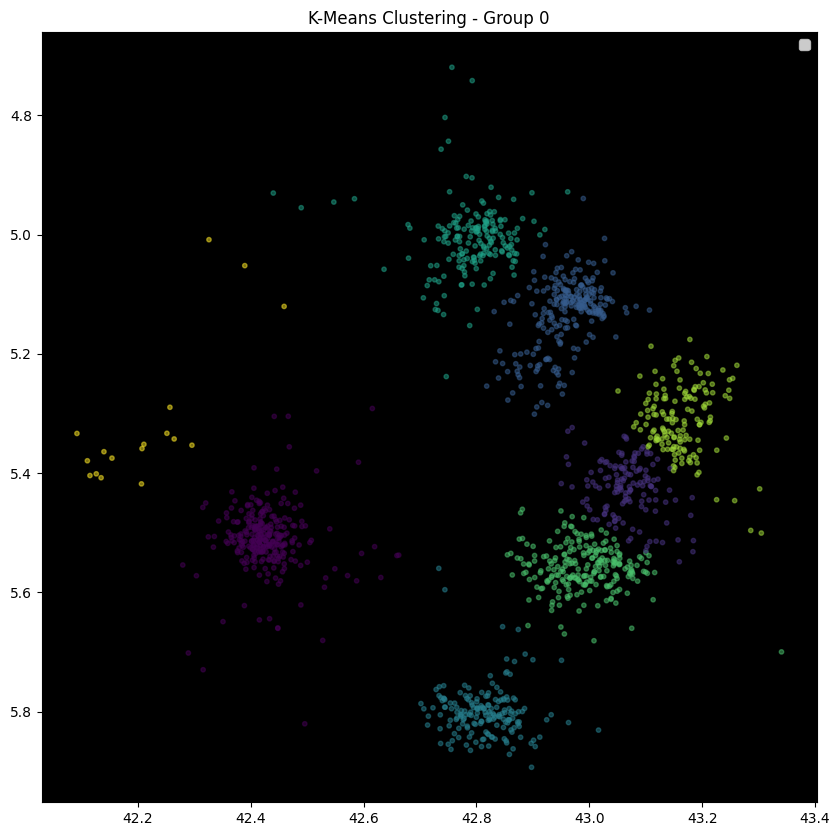

Centers of Mass (COM):
 [(np.float64(42.428676454824355), np.float64(5.510897815868419)), (np.float64(43.06698740965931), np.float64(5.424973687381609)), (np.float64(42.959169372310484), np.float64(5.132997377132012)), (np.float64(42.8155654092853), np.float64(5.799916152204021)), (np.float64(42.7921301559363), np.float64(5.007392254621623)), (np.float64(42.990956640651085), np.float64(5.558888551516411)), (np.float64(43.16330390930176), np.float64(5.311256036758423)), (np.float64(42.21997384464039), np.float64(5.311504700604607))]


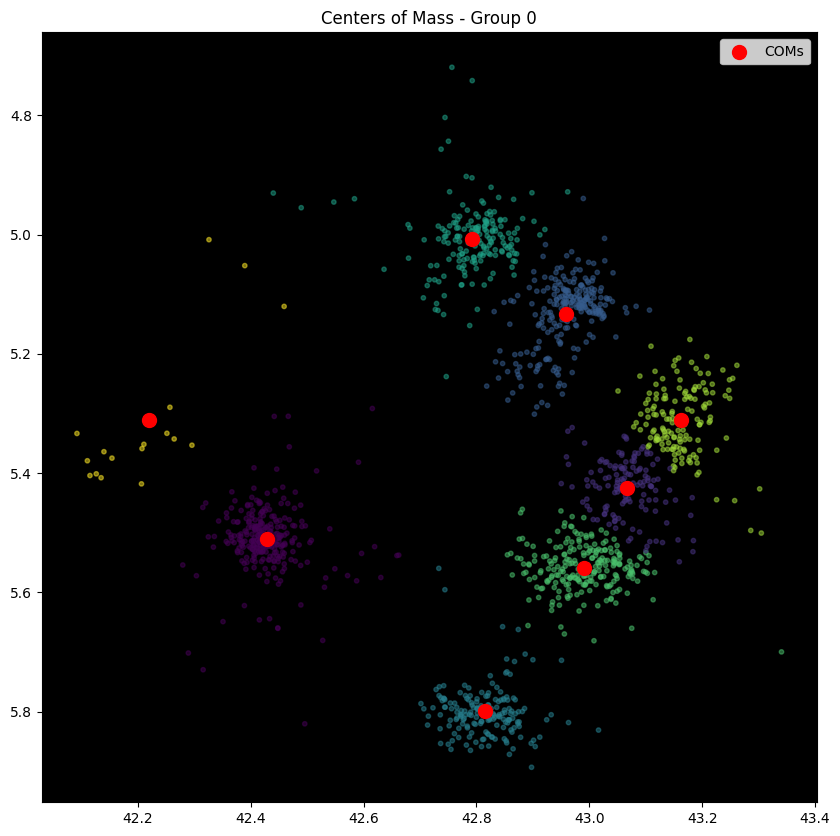

Minimum Bounding Rectangle:
 [[43.18715806  5.30249065]
 [42.5707167   4.84198937]
 [42.19912405  5.33941488]
 [42.81556541  5.79991615]]
Closest side of bounding rectangle:
 3
Rotation angle:
 4.070790253726003
Rotated Data:
 [[42.84139812  5.67818504]
 [42.84233175  5.77835704]
 [42.81704746  5.78058918]
 [42.79360644  5.74130892]
 [42.82163053  5.76971359]]
Rotated Centers of Mass (COM):
 [[42.81556541  6.28283919]
 [42.36471372  5.82288638]
 [42.19532644  6.08400483]
 [42.81556541  5.79991615]
 [42.19466829  6.2929984 ]
 [42.51750094  5.8036527 ]
 [42.21596676  5.81378078]
 [42.78072733  6.56937139]]


/tmp/ipykernel_2100/245223972.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


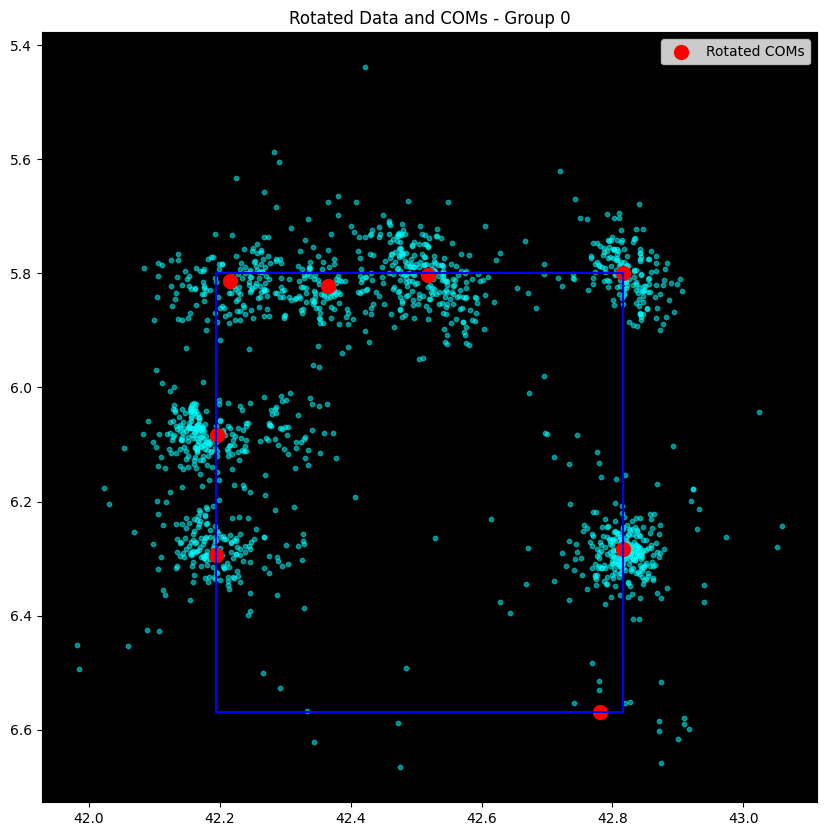

Second Highest COM:
 [42.19532644  6.08400483]
Right Most COM:
 [42.81556541  6.28283919]
Second Right Most COM:
 [42.81556541  5.79991615]
Robot COM:
 [42.51750094  5.8036527 ]


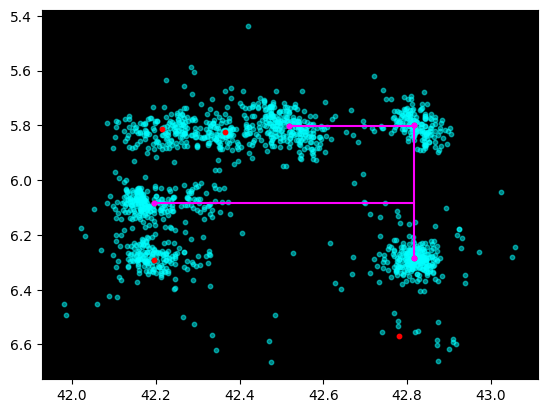

Ratio:
 0.4805639178332788

Processing Group 1
Data collected:
            x         y
0  74.181908  2.675268
1  74.218697  2.590031
2  74.369797  3.188938
3  74.364662  3.175110
4  74.386177  3.169834


/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


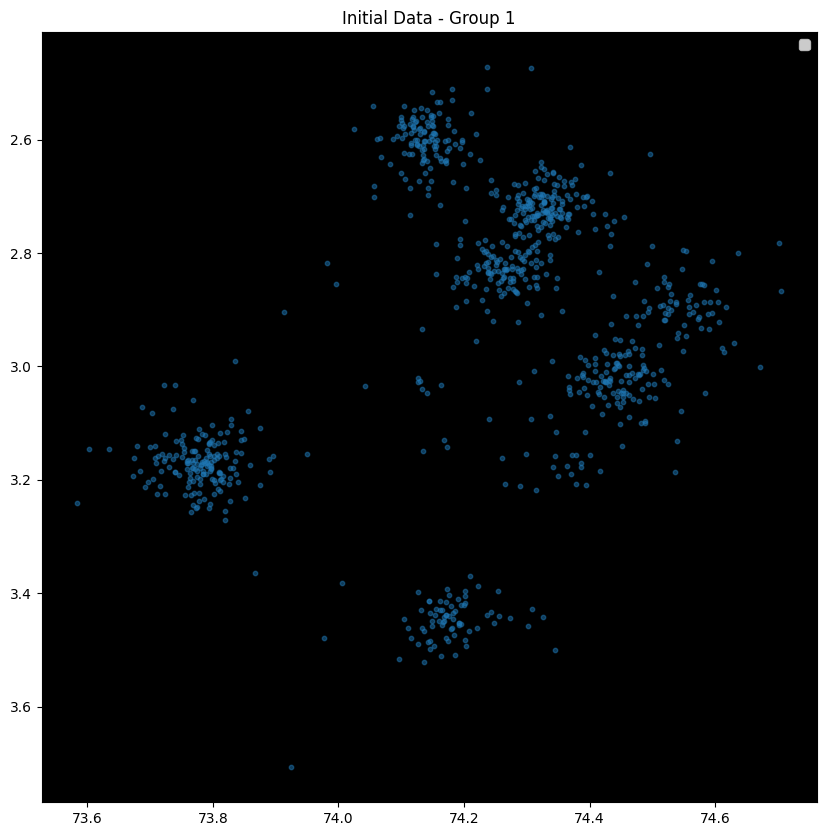

K-Means labels:
 [0 0 1 1 1 1 1 1 1 1 1 7 1 2 2 6 3 3 7 7 7 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 6 6 7 7 7 2 2 2 4 4 4 7 7 7 7 7 7 7 4 4 2 2 2 2 2 2 2 0 0 5 5 0 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 7 7 3 3 7 7 5 5 5 5 5 5 5 5 6 6 6 3 6 4 4 4 4 7 7 7 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 4 4 4 4 4 4 4 4 7 7 7 7 4
 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 5 5 5 5 5 5
 5 5 0 0 0 0 0 0 0 7 7 7 7 7 7 7 0 0 0 0 5 5 5 3 5 6 7 4 4 4 4 4 4 4 4 0 0
 6 4 4 4 7 7 7 7 7 7 7 7 7 7 7 7 5 5 4 5 5 4 0 0 6 6 6 6 6 6 5 6 6 6 6 6 6
 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 1 1 1 1 2 6 0 0 0 7 7 7
 7 1 7 7 7 7 0 5 6 6 2 2 2 2 2 2 2 2 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 1 5 0 0
 0 0 0 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 6 5 5 6 0 6 3 2 2
 2 2 2 2 2 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 7 7 1 1 1 5 6 6 0 0 0 0 0 1 2 2 2 2 2 5 5 6 6 6 6 6 6 6 6 6 6
 0 0 5 5

/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


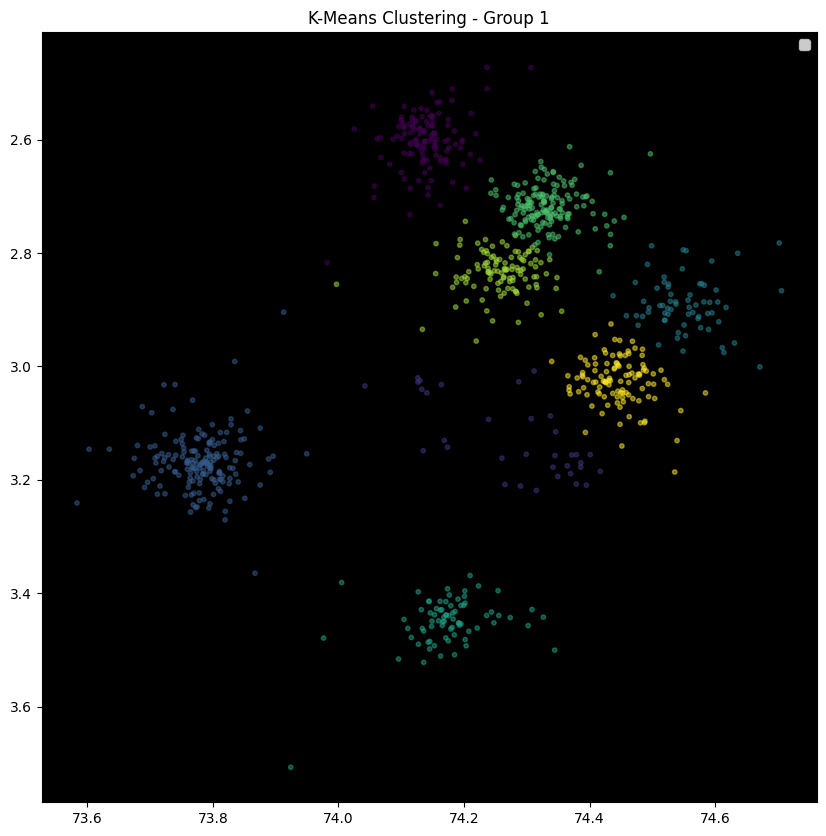

Centers of Mass (COM):
 [(np.float64(74.13930593443311), np.float64(2.602285968370674)), (np.float64(74.27897172815659), np.float64(3.127372938043931)), (np.float64(73.77946074708493), np.float64(3.168646534046013)), (np.float64(74.55210321599787), np.float64(2.89046692125725)), (np.float64(74.17461903889973), np.float64(3.4499339803059894)), (np.float64(74.33265622046686), np.float64(2.7179434299468994)), (np.float64(74.25677937000721), np.float64(2.834714855159725)), (np.float64(74.44544079981813), np.float64(3.026104297112981))]


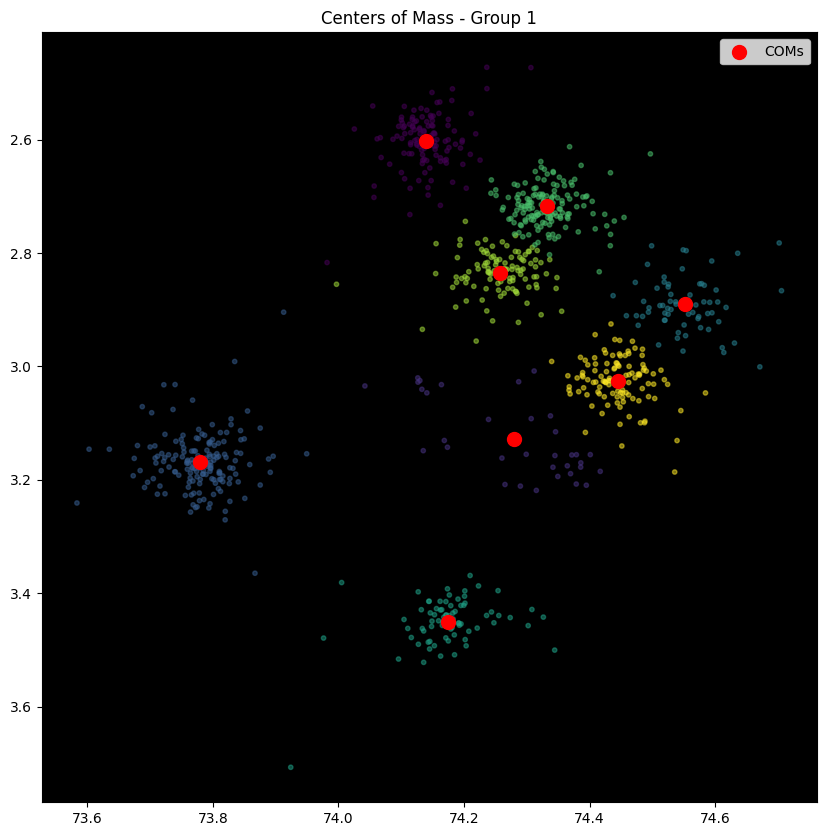

Minimum Bounding Rectangle:
 [[74.56344308  2.87366017]
 [74.14616792  2.59211586]
 [73.75734388  3.16838966]
 [74.17461904  3.44993398]]
Closest side of bounding rectangle:
 3
Rotation angle:
 4.118831004357365
Rotated Data:
 [[73.52837842  3.87717358]
 [73.43714392  3.89435156]
 [73.84909918  3.43411901]
 [73.84050839  3.44610944]
 [73.82410087  3.43122573]]
Rotated Centers of Mass (COM):
 [[73.49170733  3.95330835]
 [73.84886424  3.5438431 ]
 [74.1624617   3.93483078]
 [73.49971335  3.44993398]
 [74.17461904  3.44993398]
 [73.47943875  3.72834066]
 [73.61867609  3.72592734]
 [73.67180853  3.46248854]]


/tmp/ipykernel_2100/245223972.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


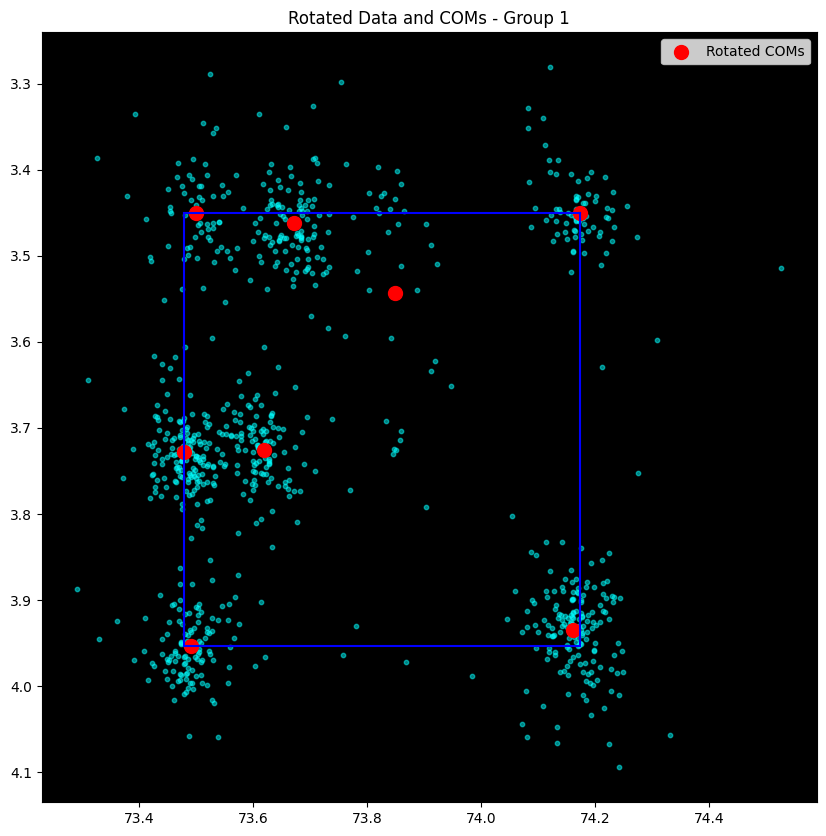

Second Highest COM:
 [73.47943875  3.72834066]
Right Most COM:
 [74.17461904  3.44993398]
Second Right Most COM:
 [74.1624617   3.93483078]
Robot COM:
 [73.61867609  3.72592734]


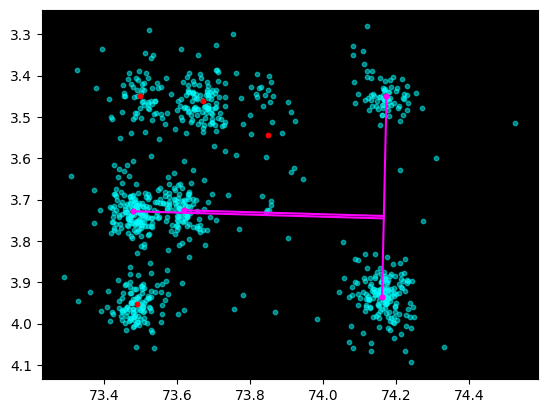

Ratio:
 0.7977668958674706

Processing Group 2
Data collected:
            x          y
0  80.229553  11.981121
1  80.168312  11.962978
2  80.124626  11.972430
3  80.120476  11.994550
4  80.130730  11.978308


/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


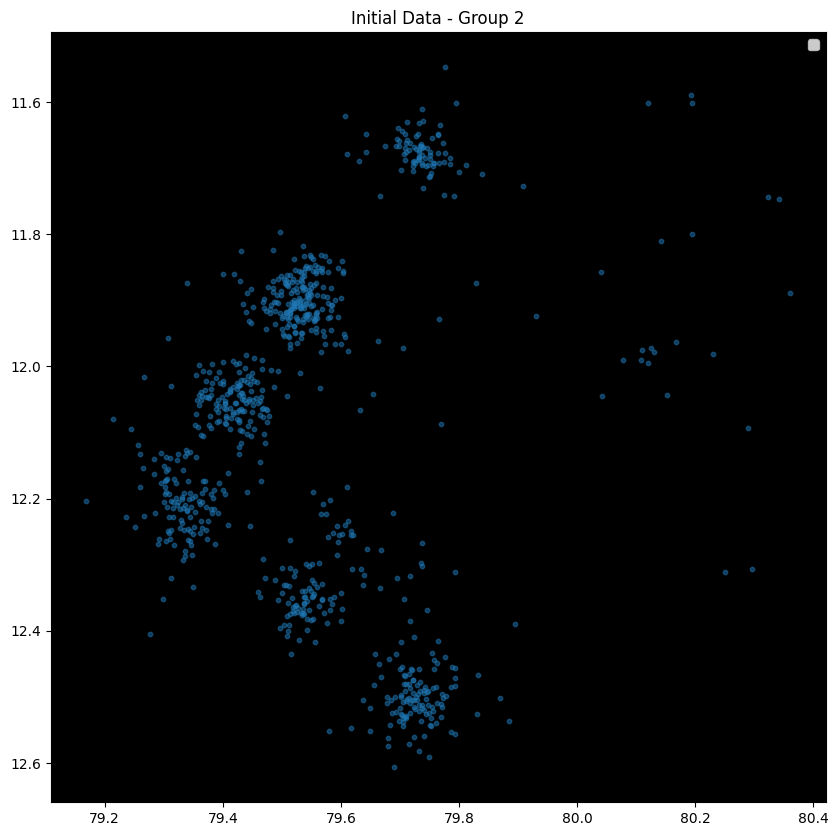

K-Means labels:
 [4 4 4 4 4 6 6 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 1 3 7 1 6 6 6 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 6 6 6 5 5 5 5 5 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 2 2 2 1 3 3 3 3 3 3 3 3 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 6 7 7 3 0 0
 0 0 0 6 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 2 2 5 5 5 5 6 3 3 3 3 3 2 5 5 0 0 0 0 0 0 0 0 5 5 2 2 5
 3 3 3 3 3 3 5 1 1 0 0 5 5 5 5 2 2 2 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 6 2 2 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 0 0 5 1
 0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 6 3 3 3 3 3 3 3 7 7 0 3 3 3 1 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 6 6 6 6 6 6 6 6 6 6 6 1 1 1 2 2 6 2
 2 2 1 1 1 1 1 1 1 1 1 0 0 5 5 1 1 1 1 5 7 4 5 5 5 1 1 1 1 2 2 2 2 1 2 2 0
 0 0 0 0

/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


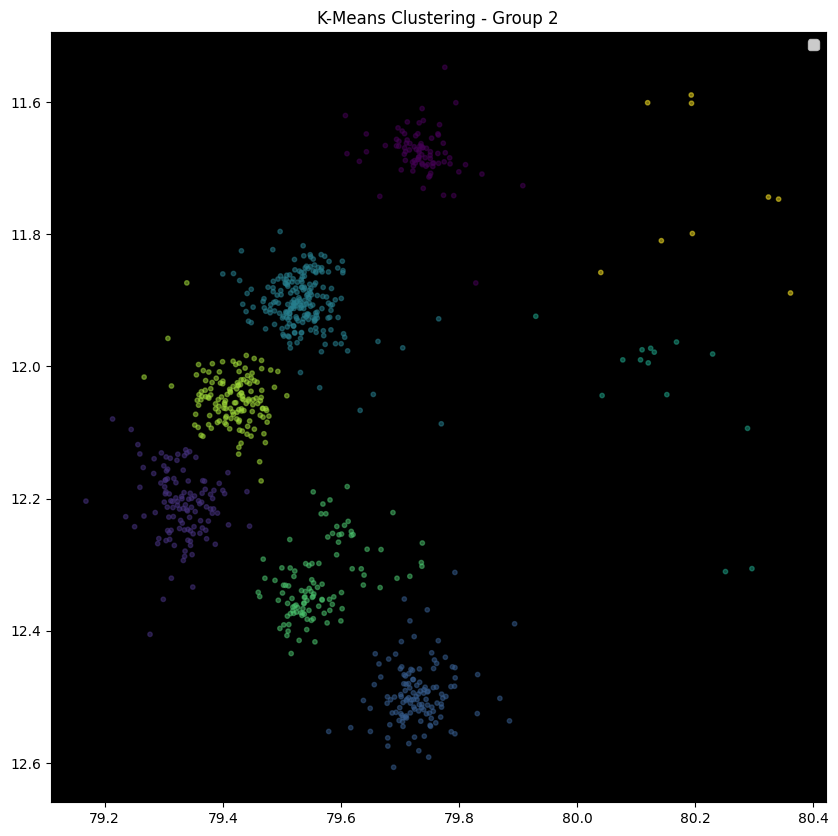

Centers of Mass (COM):
 [(np.float64(79.73547944568452), np.float64(11.677294004531134)), (np.float64(79.33030194194377), np.float64(12.20881382757876)), (np.float64(79.72952196674962), np.float64(12.496960755317442)), (np.float64(79.5342530664408), np.float64(11.903688759173987)), (np.float64(80.14492579868862), np.float64(12.040319034031459)), (np.float64(79.56182626029042), np.float64(12.327570995437764)), (np.float64(79.41719585445756), np.float64(12.050053156859486)), (np.float64(80.21236504448785), np.float64(11.737446784973145))]


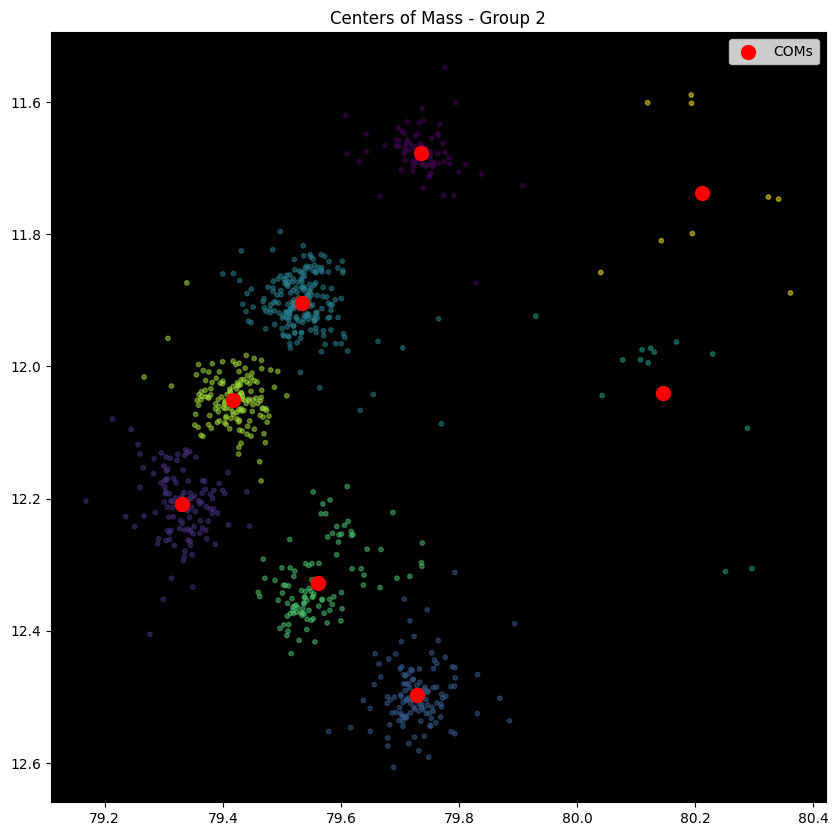

Minimum Bounding Rectangle:
 [[80.32508043 11.83763157]
 [79.91608249 11.47410205]
 [79.29273076 12.17541945]
 [79.70172871 12.53894897]]
Closest side of bounding rectangle:
 1
Rotation angle:
 0.8441870576560846
Rotated Data:
 [[79.74537149 12.04523245]
 [79.71824702 11.987406  ]
 [79.68216013 11.96103302]
 [79.66287004 11.97262575]
 [79.68182191 11.96949963]]
Rotated Centers of Mass (COM):
 [[79.6442288  11.47410205]
 [78.97777898 11.52436912]
 [79.02762643 12.01418593]
 [79.34133172 11.47410205]
 [79.64490376 12.0213068 ]
 [79.04282682 11.77631267]
 [79.1541687  11.48384542]
 [79.91608249 11.87050311]]


/tmp/ipykernel_2100/245223972.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


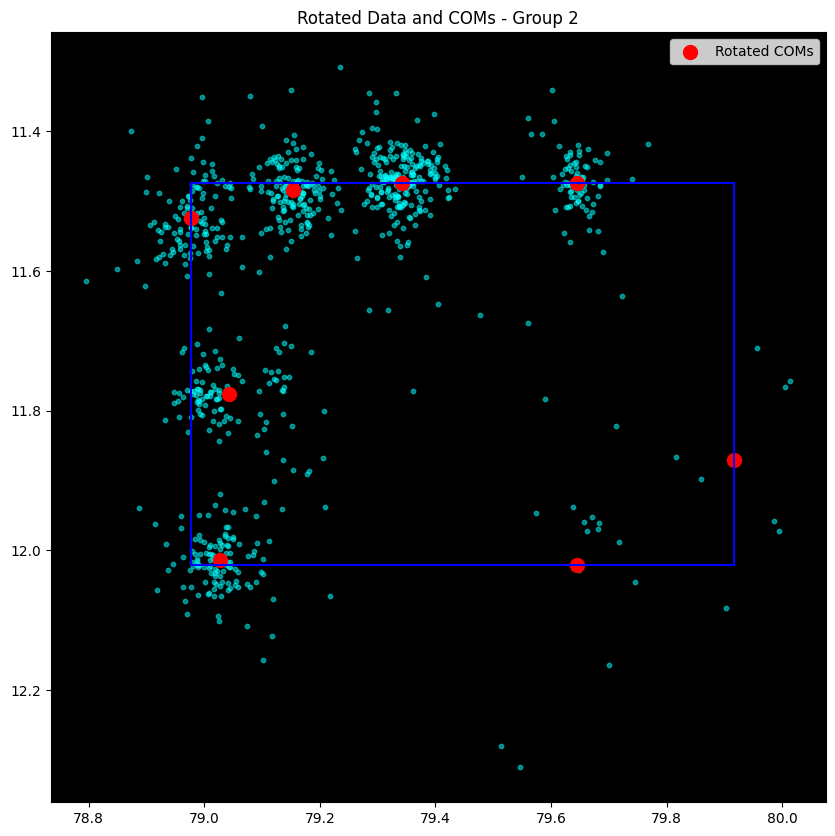

Second Highest COM:
 [79.04282682 11.77631267]
Right Most COM:
 [79.91608249 11.87050311]
Second Right Most COM:
 [79.64490376 12.0213068 ]
Robot COM:
 [79.34133172 11.47410205]


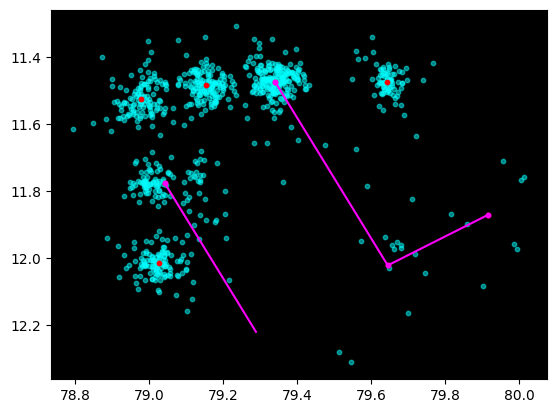

Ratio:
 1.234922341201315

Processing Group 3
Data collected:
            x         y
0  96.276115  5.262790
1  96.280777  5.182926
2  96.253075  5.196754
3  96.216118  5.205290
4  96.236908  5.174649


/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


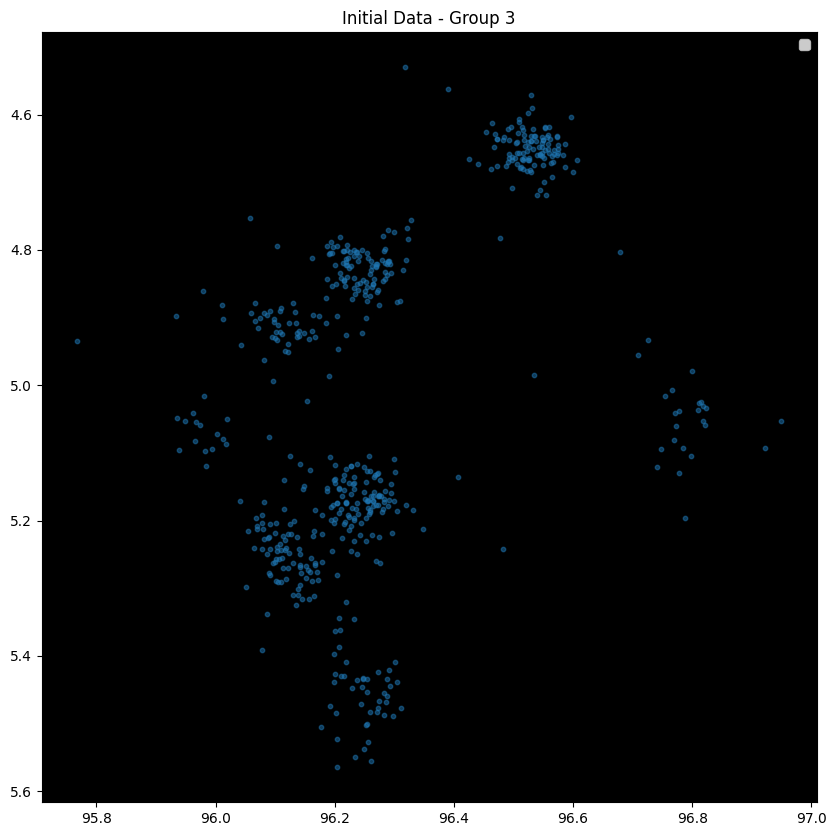

K-Means labels:
 [3 3 3 3 3 2 2 2 2 2 2 2 2 0 0 0 0 0 0 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 1
 1 1 1 1 1 5 5 5 7 7 7 1 1 1 1 0 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 7 7 7 7 7 7 7 7 3 3 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 5 2 2 2 2 2 2 2
 1 1 2 2 2 2 2 1 1 1 1 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 0 0
 0 0 0 3 7 7 7 6 6 6 6 3 6 3 7 7 7 7 7 7 7 7 7 7 7 2 2 2 2 2 2 2 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3
 3 3 7 3 7 7 2 2 2 2 2 2 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 3 7 7 0 0
 0 0 0 5 5 7 3 3 0 7 7 7 3 3 5 5 5 5 7 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 3
 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 2 2 2 6 6 6 0 0 0 0 0 7 4 4 4 4 4 4 4
 4 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 3 3 3 3 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 7 7
 3 7 7 3 3 3 3 6 6 6 7 7 7 3 3 6 3 3 3 4 2 2 2 2 2 2 2 3 4 4 2 2 3 3 5 3 3
 3 3 4 4 4 3 3 3 3 4 4 4 6 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3
 3 4 7 7

/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


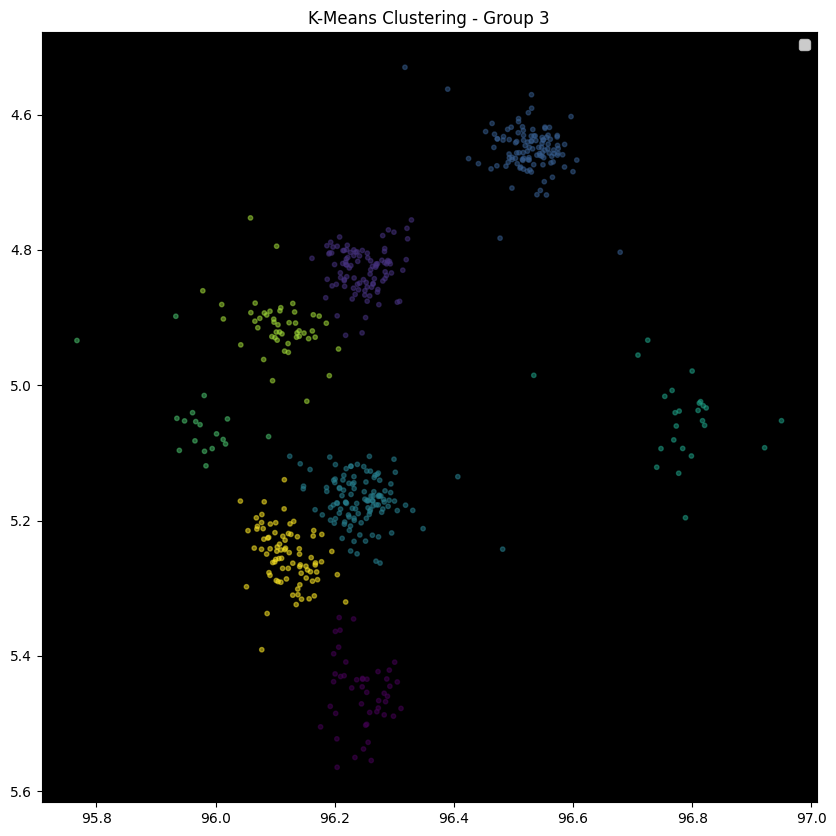

Centers of Mass (COM):
 [(np.float64(96.24598710433297), np.float64(5.454964492631995)), (np.float64(96.2470948961046), np.float64(4.829189396867848)), (np.float64(96.52659242343059), np.float64(4.651792268837448)), (np.float64(96.24395824300832), np.float64(5.169995365471675)), (np.float64(96.78432647705078), np.float64(5.049751472473145)), (np.float64(95.97059546576605), np.float64(5.053029855092366)), (np.float64(96.10949961344402), np.float64(4.912443409363429)), (np.float64(96.12027545091583), np.float64(5.252703178219679))]


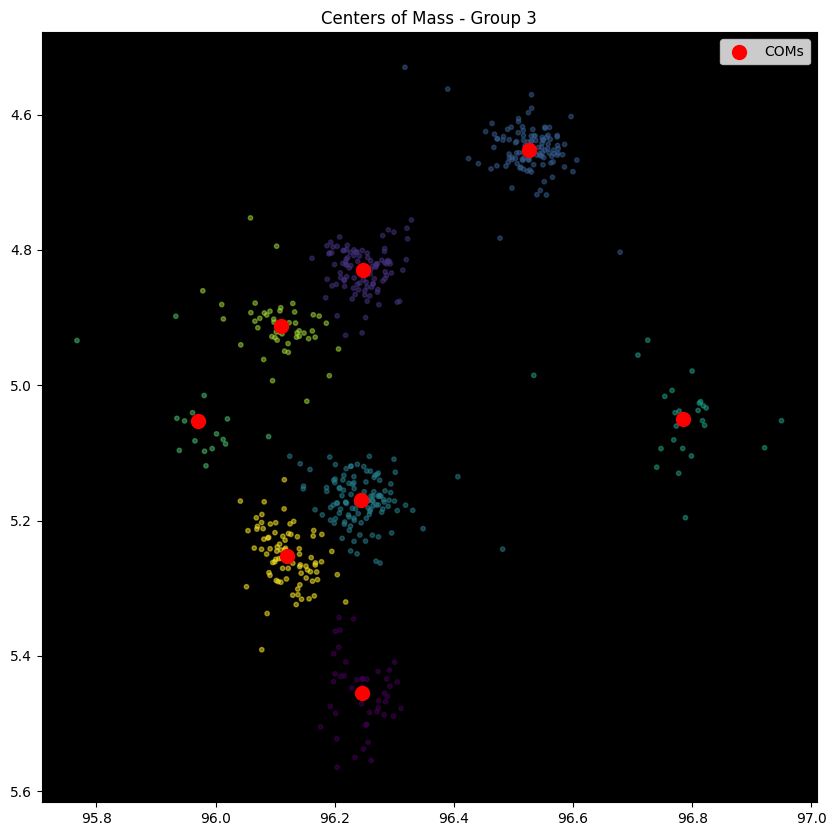

Minimum Bounding Rectangle:
 [[96.81144371  5.06753329]
 [96.51487669  4.63469313]
 [95.94942008  5.02212434]
 [96.2459871   5.45496449]]
Closest side of bounding rectangle:
 2
Rotation angle:
 2.1714965305334952
Rotated Data:
 [[95.56623036  5.15559919]
 [95.62947897  5.20458573]
 [95.633729    5.17391667]
 [95.64757615  5.1386049 ]
 [95.66110261  5.17307471]]
Rotated Centers of Mass (COM):
 [[95.42472722  5.02212434]
 [95.94032801  5.37673895]
 [95.92869235  5.7075761 ]
 [95.66095642  5.18152097]
 [95.45472336  5.69525665]
 [95.91195613  5.02212434]
 [95.94942008  5.21617424]
 [95.66263545  5.03274195]]


/tmp/ipykernel_2100/245223972.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


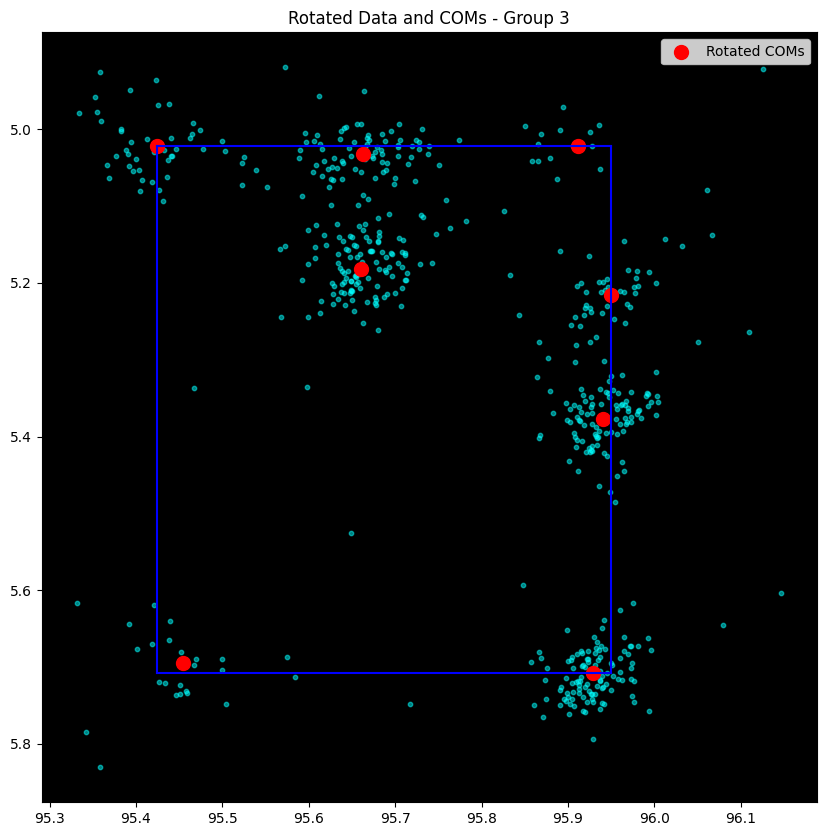

Second Highest COM:
 [95.66095642  5.18152097]
Right Most COM:
 [95.94942008  5.21617424]
Second Right Most COM:
 [95.94032801  5.37673895]
Robot COM:
 [95.66095642  5.18152097]


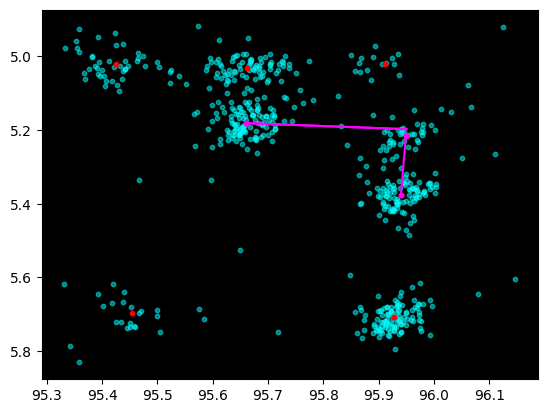

Ratio:
 1.0

Processing Group 4
Data collected:
             x          y
0  154.937286  12.149701
1  154.065964  12.067630
2  154.442245  12.426337
3  154.473663  12.418509
4  154.446823  12.387403


/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


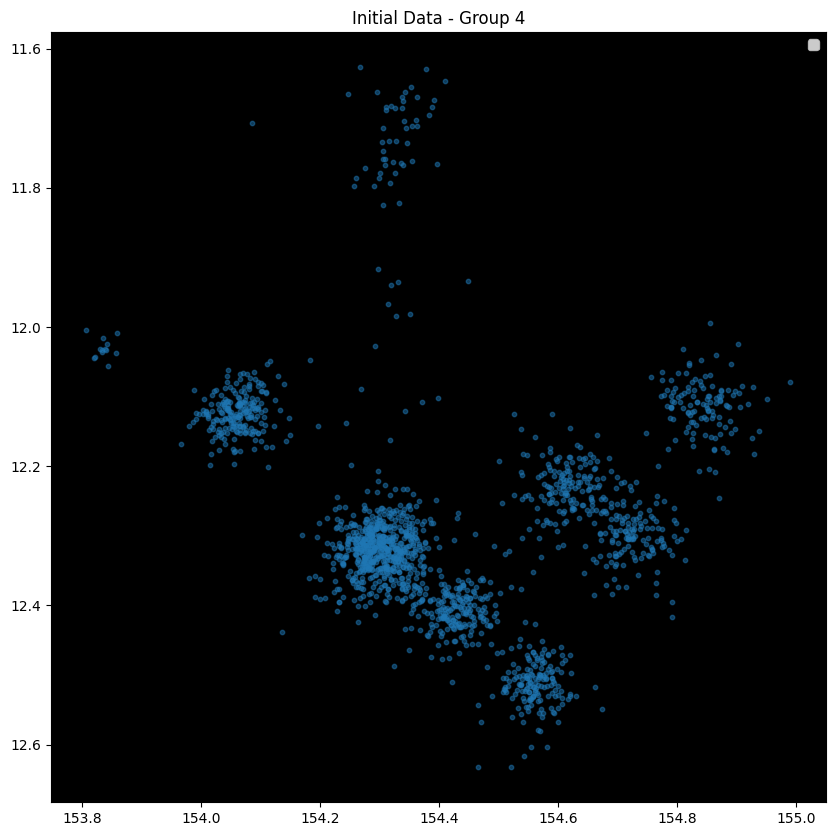

K-Means labels:
 [5 2 6 ... 7 7 7]


/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


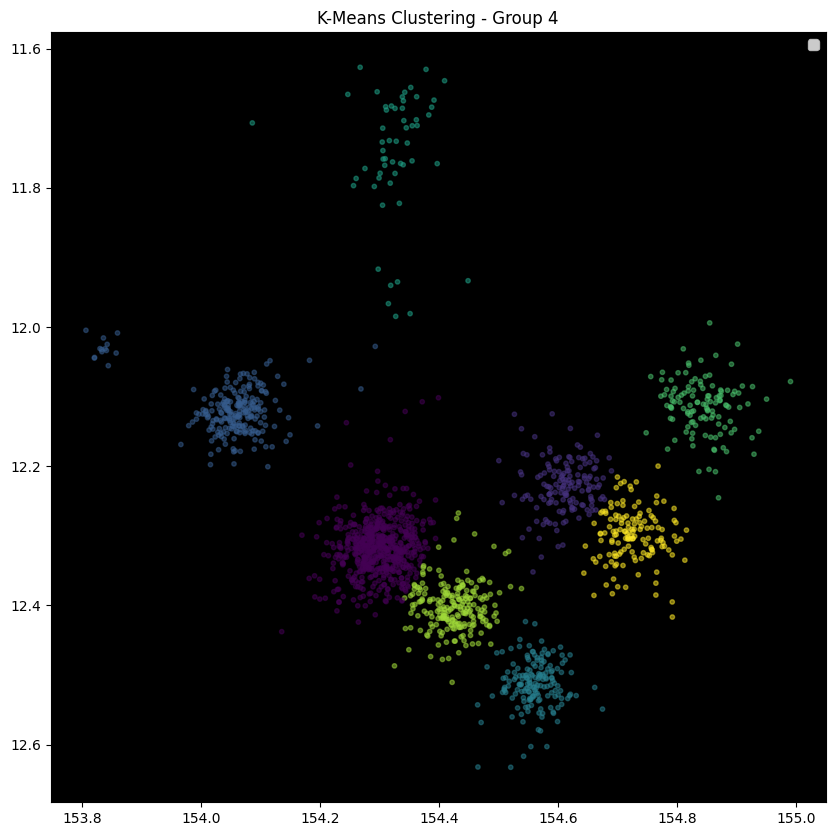

Centers of Mass (COM):
 [(np.float64(154.29785808378548), np.float64(12.317404563916545)), (np.float64(154.61018541124133), np.float64(12.228910165674547)), (np.float64(154.05118603727), np.float64(12.117638014095686)), (np.float64(154.56031336103166), np.float64(12.51306314695449)), (np.float64(154.32502330433238), np.float64(11.752556471391157)), (np.float64(154.84418657791517), np.float64(12.113616872424922)), (np.float64(154.42449521151457), np.float64(12.401920357617465)), (np.float64(154.72539646505453), np.float64(12.2999210563495))]


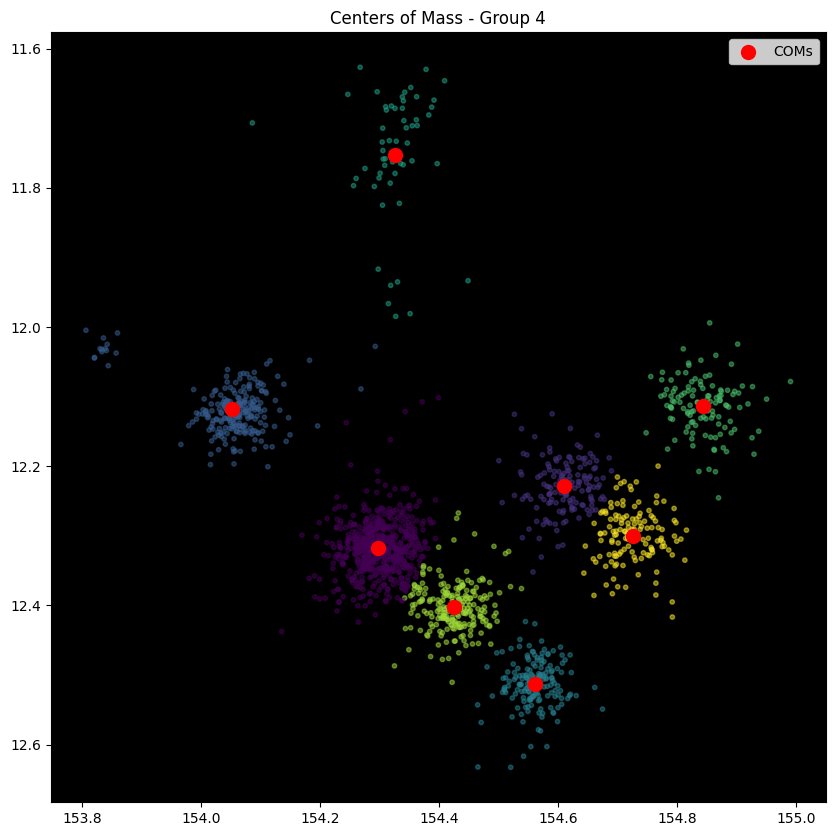

Minimum Bounding Rectangle:
 [[154.85710526  12.12324766]
 [154.33639433  11.73506128]
 [154.04357937  12.12784155]
 [154.5642903   12.51602793]]
Closest side of bounding rectangle:
 2
Rotation angle:
 2.500982243409653
Rotated Data:
 [[153.31400156  12.64447128]
 [154.06162077  12.18949398]
 [153.54554998  12.12680501]
 [153.52504042  12.15185951]
 [153.56515064  12.16075616]]
Rotated Centers of Mass (COM):
 [[153.72641727  12.12784155]
 [153.52890651  12.3854636 ]
 [154.04357937  12.14056844]
 [153.39905653  12.12784155]
 [154.04223926  12.59693406]
 [153.41020957  12.61775679]
 [153.57437453  12.13577172]
 [153.39409609  12.39739187]]


/tmp/ipykernel_2100/245223972.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


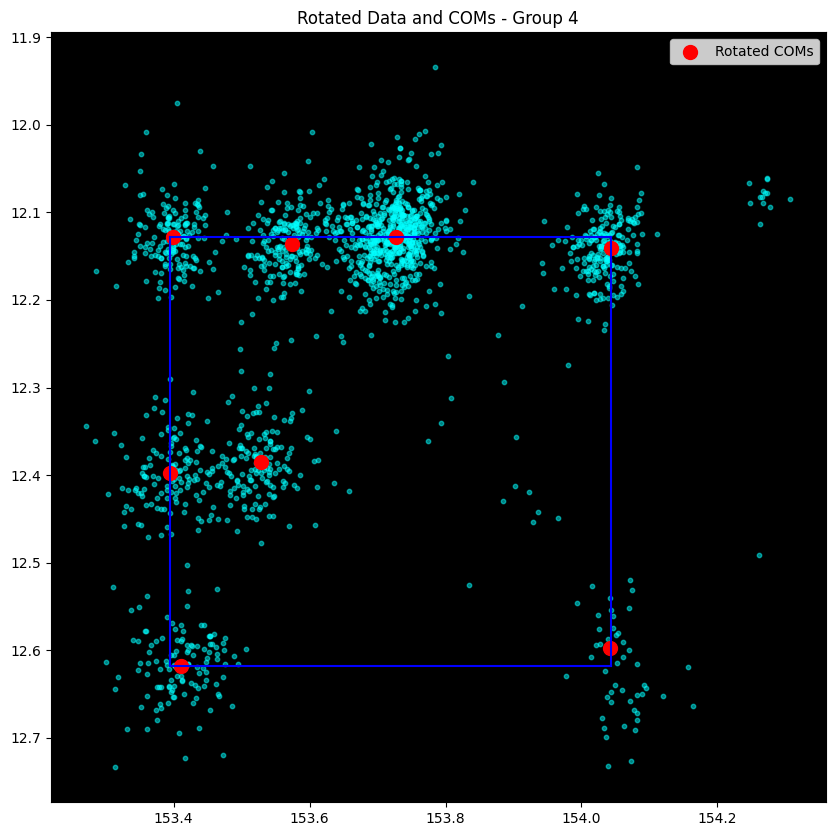

Second Highest COM:
 [153.39409609  12.39739187]
Right Most COM:
 [154.04357937  12.14056844]
Second Right Most COM:
 [154.04223926  12.59693406]
Robot COM:
 [153.52890651  12.3854636 ]


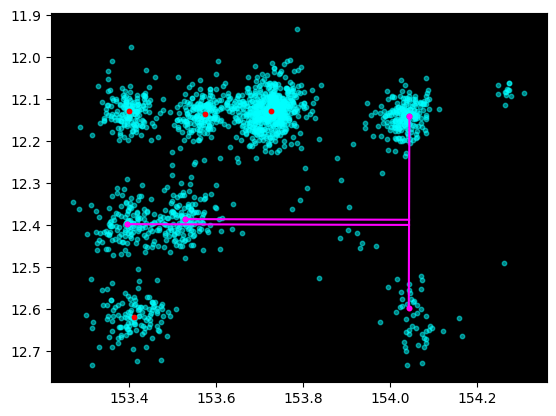

Ratio:
 0.7922470414939748

Processing Group 5
Data collected:
             x          y
0  190.320480  16.102219
1  190.276398  16.173414
2  190.258575  16.114859
3  190.139954  16.050495
4  190.059372  16.388666


/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


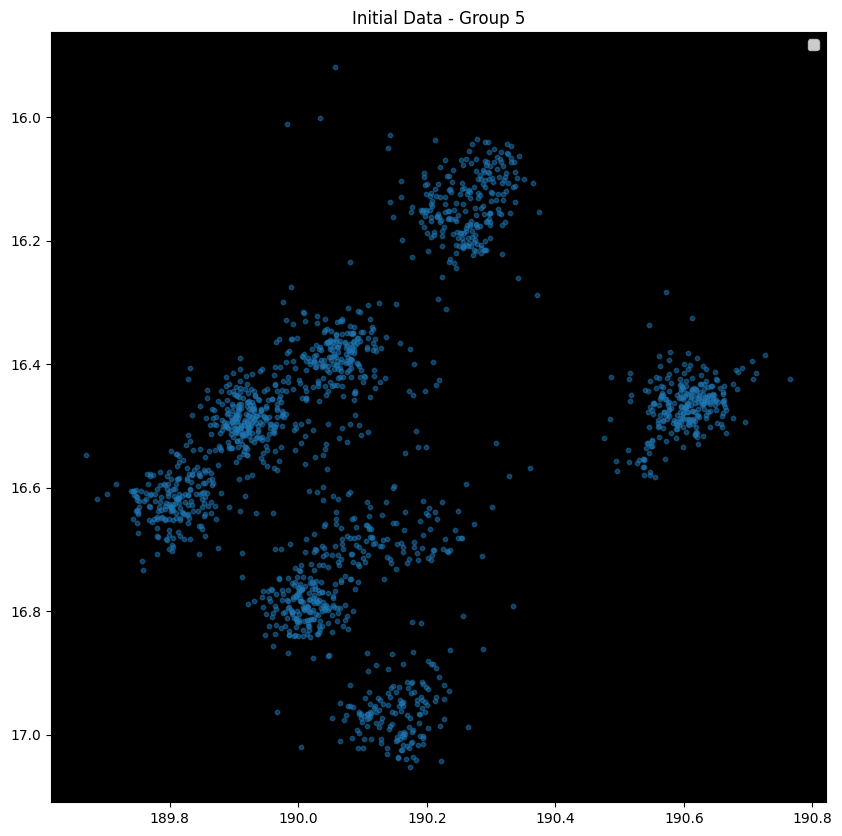

K-Means labels:
 [1 1 1 ... 3 3 3]


/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


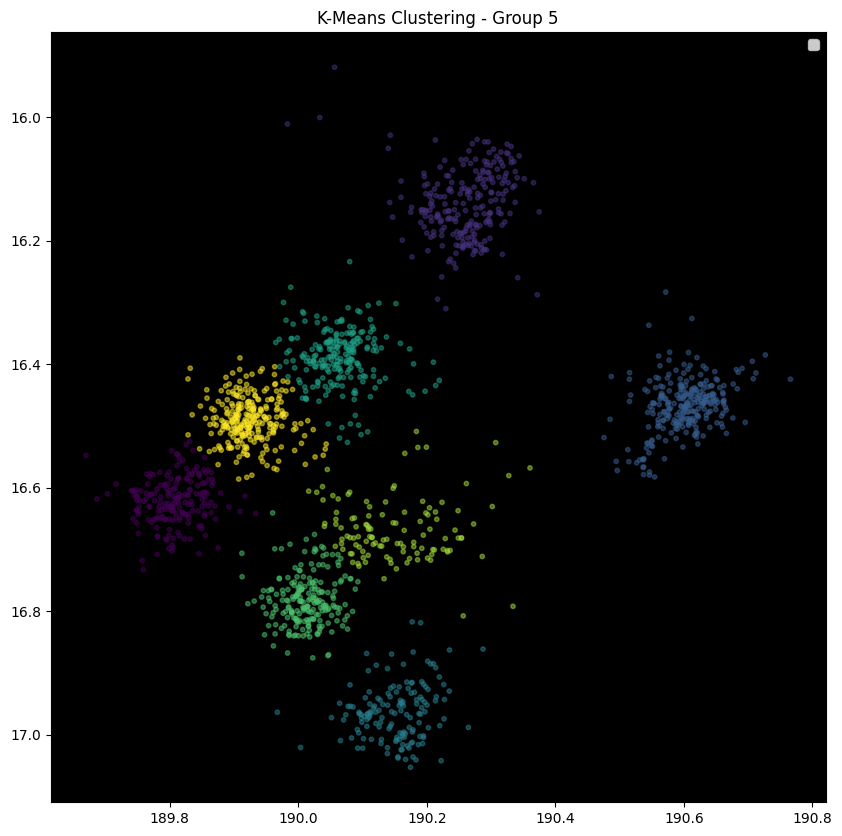

Centers of Mass (COM):
 [(np.float64(189.808189002835), np.float64(16.620651176997594)), (np.float64(190.25993032823817), np.float64(16.14046060783157)), (np.float64(190.60105555651356), np.float64(16.46740259645597)), (np.float64(190.1514623245137), np.float64(16.963087056307184)), (np.float64(190.0642186505762), np.float64(16.389368635496943)), (np.float64(190.01223790701567), np.float64(16.78151156644866)), (np.float64(190.14929564386352), np.float64(16.66652112129407)), (np.float64(189.92427917709924), np.float64(16.489982612150953))]


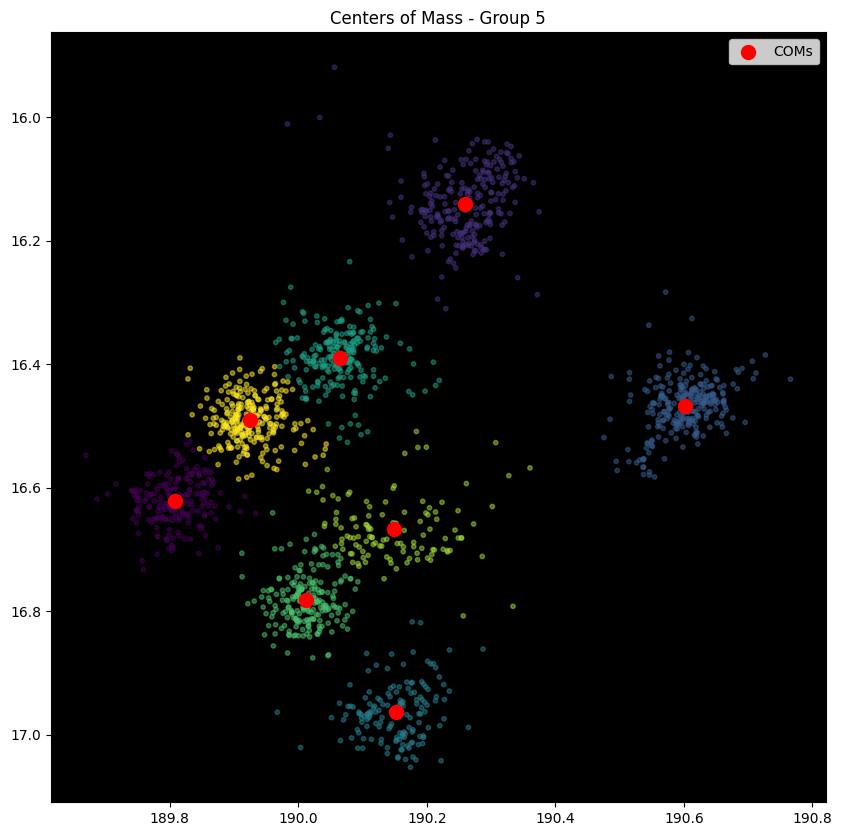

Minimum Bounding Rectangle:
 [[190.61433717  16.48013199]
 [190.25958554  16.14013015]
 [189.79671069  16.62308522]
 [190.15146232  16.96308706]]
Closest side of bounding rectangle:
 1
Rotation angle:
 0.8066252330097616
Rotated Data:
 [[190.32909148  16.15786108]
 [190.24718888  16.17529835]
 [190.27713154  16.12191456]
 [190.24152011  15.99173921]
 [189.94161789  16.16755642]]
Rotated Centers of Mass (COM):
 [[189.60033165  16.14673279]
 [190.25958554  16.14060773]
 [190.25958554  16.61310904]
 [189.59063209  16.63150575]
 [189.94446435  16.1715416 ]
 [189.62538685  16.4053527 ]
 [189.80324048  16.42473602]
 [189.77499592  16.14013015]]


/tmp/ipykernel_2100/245223972.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


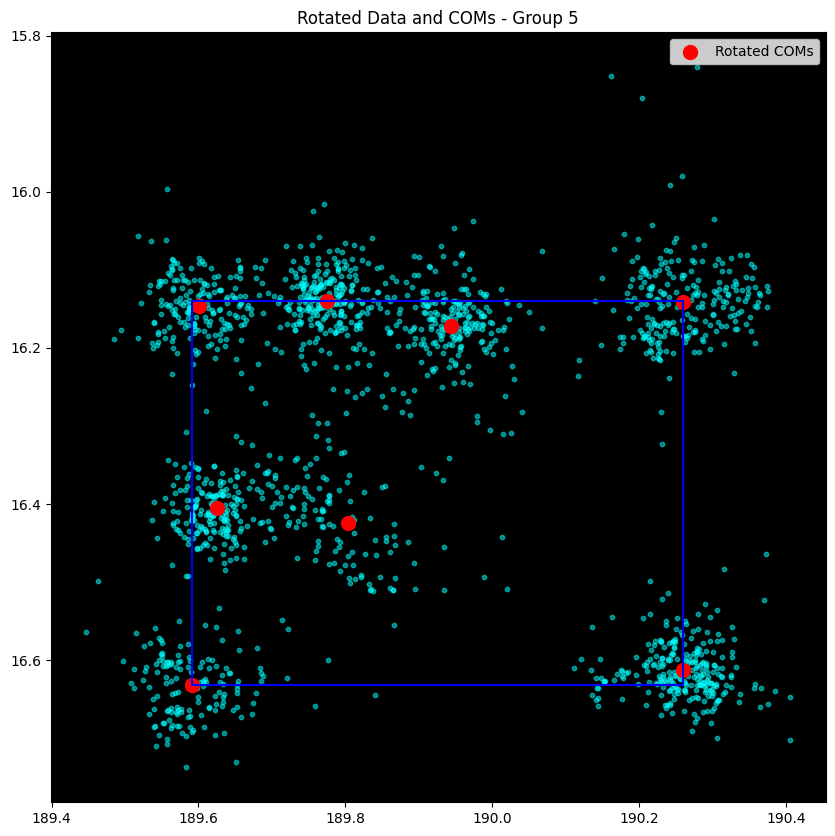

Second Highest COM:
 [189.62538685  16.4053527 ]
Right Most COM:
 [190.25958554  16.14060773]
Second Right Most COM:
 [190.25958554  16.61310904]
Robot COM:
 [189.80324048  16.42473602]


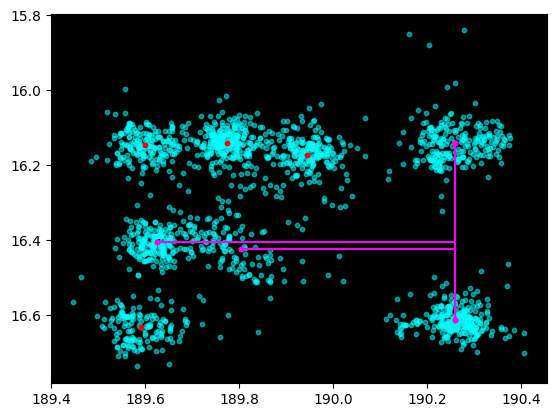

Ratio:
 0.7195616600047895

Processing Group 6
Data collected:
             x         y
0  192.853226  3.511629
1  192.808411  3.494667
2  192.990067  3.477808
3  192.797516  3.549601
4  192.846237  3.472739


/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


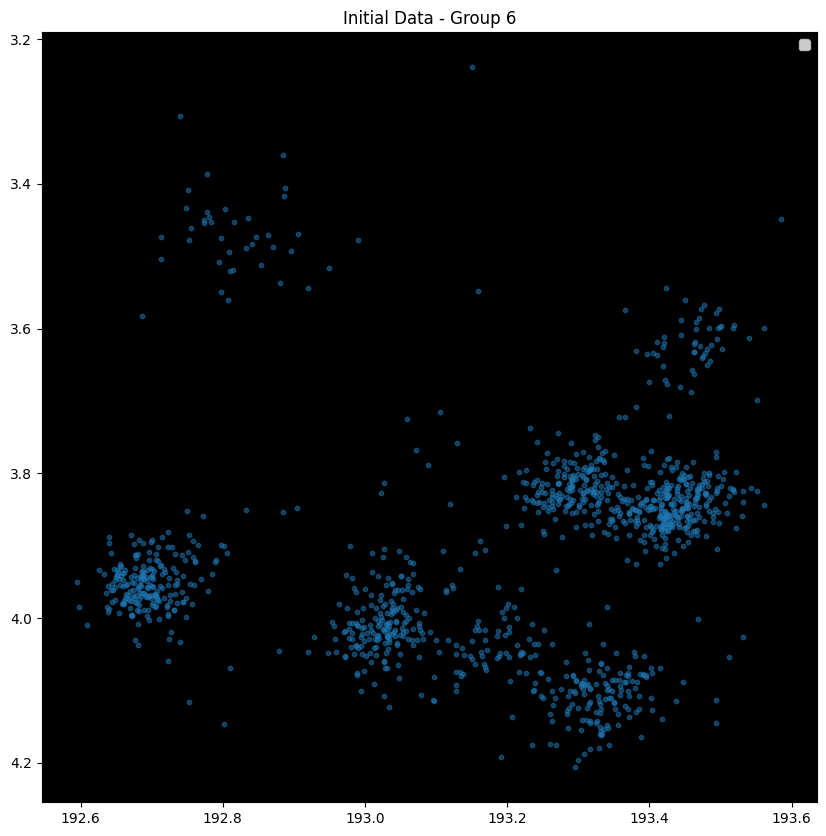

/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


K-Means labels:
 [3 3 3 ... 0 0 4]


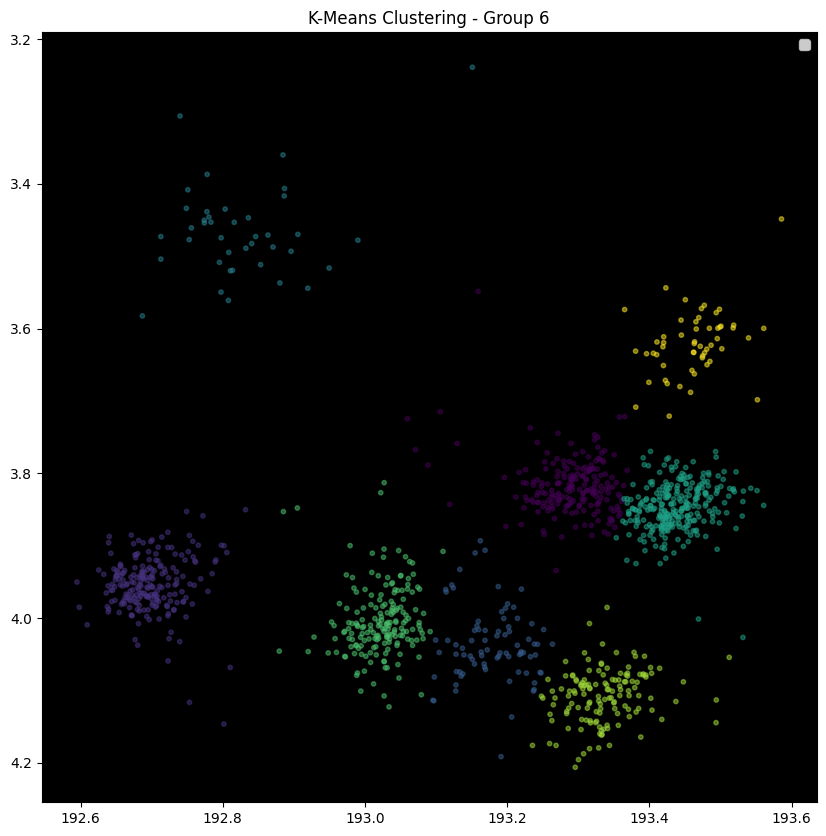

Centers of Mass (COM):
 [(np.float64(193.2893615415947), np.float64(3.8175938009616717)), (np.float64(192.69750955071248), np.float64(3.9537883241411667)), (np.float64(193.17829009633004), np.float64(4.0361552238464355)), (np.float64(192.82681579589843), np.float64(3.46524173617363)), (np.float64(193.43850013925712), np.float64(3.8464720576248443)), (np.float64(193.02164210535545), np.float64(4.003581663521614)), (np.float64(193.33668298515485), np.float64(4.107724654588768)), (np.float64(193.4624910707827), np.float64(3.620672071421588))]


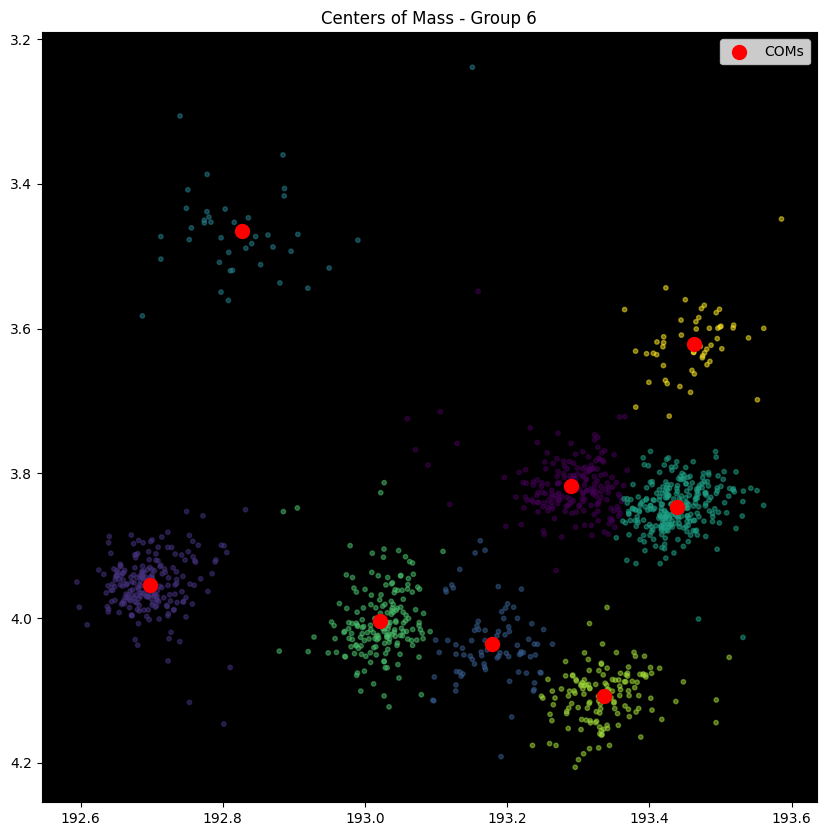

Minimum Bounding Rectangle:
 [[193.49194976   3.62787508]
 [192.81752084   3.46296901]
 [192.69750955   3.95378832]
 [193.37193847   4.1186944 ]]
Closest side of bounding rectangle:
 2
Rotation angle:
 2.9017856471540036
Rotated Data:
 [[192.65126885   4.42027936]
 [192.69883028   4.42611199]
 [192.52637686   4.48563417]
 [192.69636563   4.3701623 ]
 [192.6672945    4.45639718]]
Rotated Centers of Mass (COM):
 [[192.15494236   4.2266593 ]
 [192.69750955   3.95378832]
 [192.21092371   3.98797112]
 [192.68794078   4.45906677]
 [192.00321251   4.23403011]
 [192.37082575   3.98240627]
 [192.0400646    3.95607044]
 [192.03353903   4.45906677]]


/tmp/ipykernel_2100/245223972.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


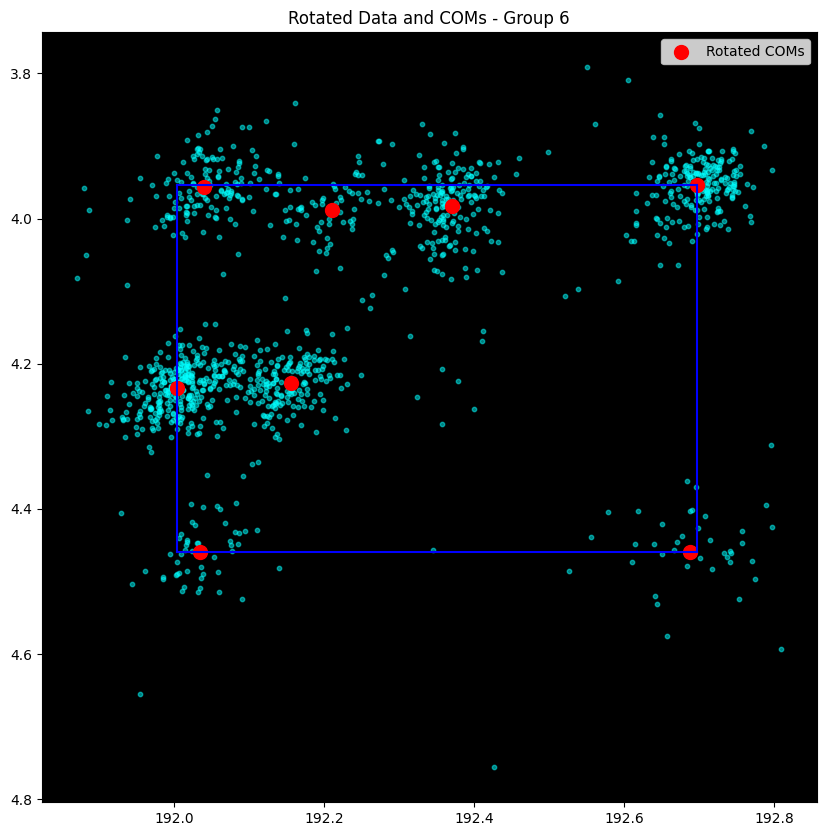

Second Highest COM:
 [192.00321251   4.23403011]
Right Most COM:
 [192.69750955   3.95378832]
Second Right Most COM:
 [192.68794078   4.45906677]
Robot COM:
 [192.15494236   4.2266593 ]


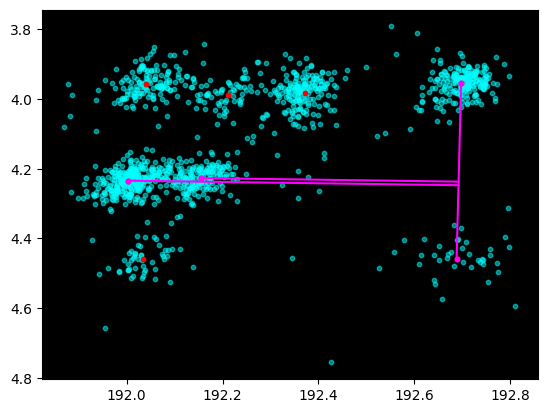

Ratio:
 0.7799818899101107

Processing Group 7
Data collected:
             x          y
0  223.384872  14.570362
1  223.379608  14.605626
2  223.415466  14.562952
3  223.395050  14.599780
4  223.444214  14.630434


/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


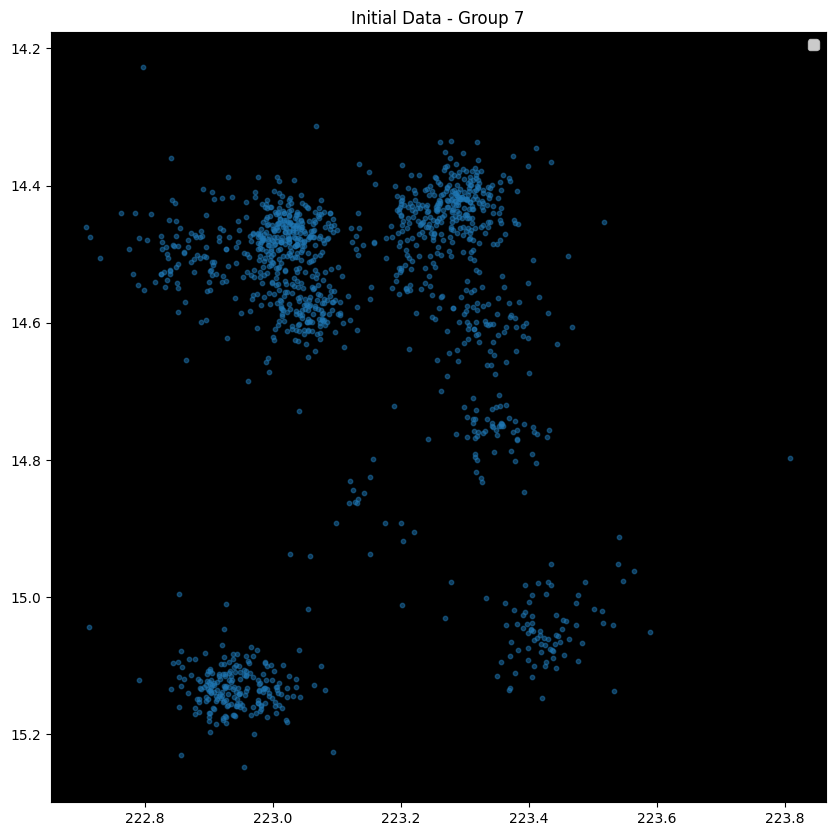

K-Means labels:
 [7 7 7 ... 1 3 5]


/tmp/ipykernel_2100/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


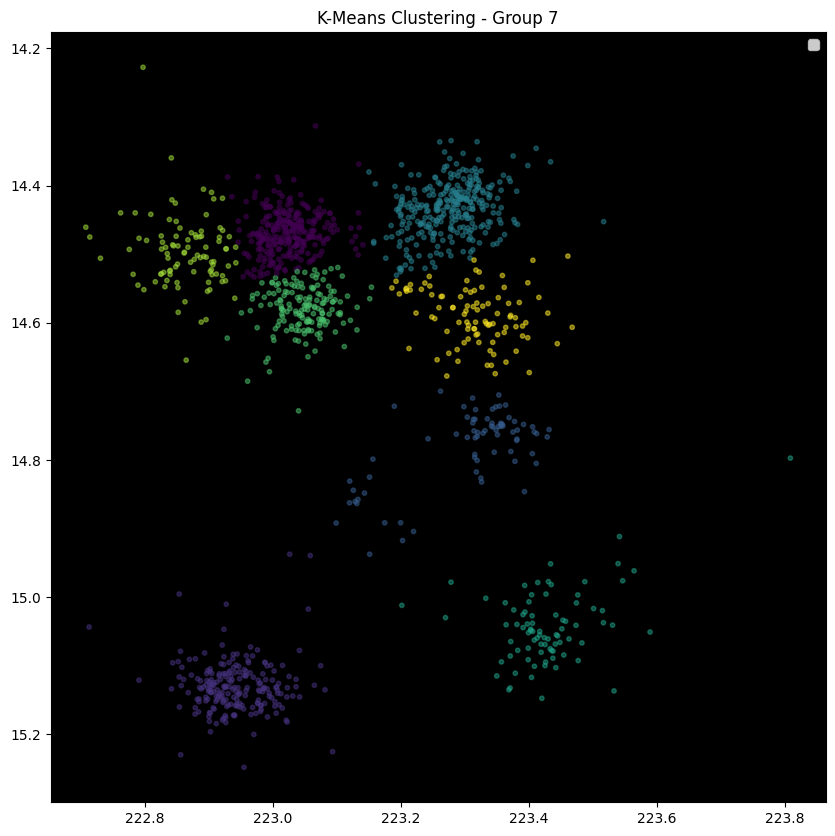

Centers of Mass (COM):
 [(np.float64(223.02327102551357), np.float64(14.468674906723791)), (np.float64(222.94146528867918), np.float64(15.129941155977338)), (np.float64(223.30488359605943), np.float64(14.781124321190086)), (np.float64(223.2758379803588), np.float64(14.434095480584151)), (np.float64(223.42969177990426), np.float64(15.043157368171507)), (np.float64(223.04771252744686), np.float64(14.580076727067462)), (np.float64(222.86249915589678), np.float64(14.496709935208584)), (np.float64(223.31608420924135), np.float64(14.589184811240749))]


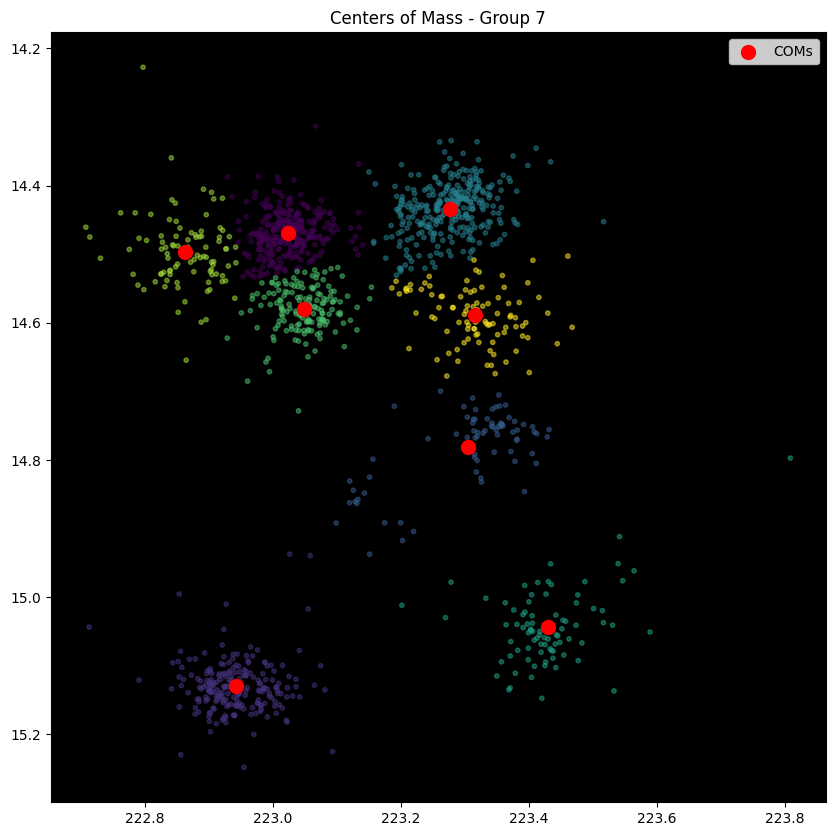

Minimum Bounding Rectangle:
 [[223.42997067  15.04475671]
 [223.32047752  14.41684872]
 [222.83197214  14.50203317]
 [222.94146529  15.12994116]]
Closest side of bounding rectangle:
 1
Rotation angle:
 0.17264179215268438
Rotated Data:
 [[223.3575438   14.57914213]
 [223.34629993  14.6129776 ]
 [223.38895581  14.57709782]
 [223.36251653  14.60987117]
 [223.4056836   14.64851506]]
Rotated Centers of Mass (COM):
 [[223.0187862   14.41684872]
 [222.82460062  15.0542318 ]
 [223.24253816  14.77303033]
 [223.27353883  14.42617067]
 [223.32047752  15.05260833]
 [223.02372715  14.53079318]
 [222.85558829  14.41684872]
 [223.28654468  14.58586822]]


/tmp/ipykernel_2100/245223972.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


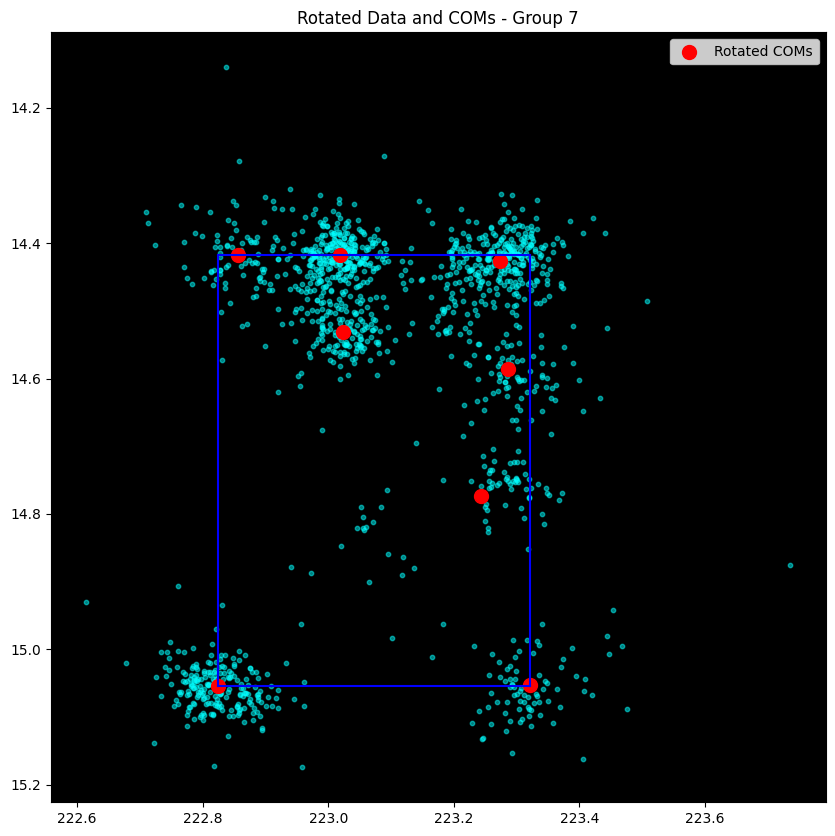

Second Highest COM:
 None
Right Most COM:
 [223.32047752  15.05260833]
Second Right Most COM:
 [223.28654468  14.58586822]
Robot COM:
 [223.02372715  14.53079318]


TypeError: cannot unpack non-iterable NoneType object

In [7]:
# Example usage
filename = 'data/n=10_origmi_locs.hdf5'
k = 8
process_multiple_origami_ratio(filename, k)